In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from typing import Generator

In [2]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, max_diff: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            if timeX - timeY > max_diff:
                tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
                X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
        if timeY - timeX > max_diff:
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

In [3]:
df_X1 = load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx')
df_X2 = load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx')
df_X3 = load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx')

In [4]:
def remove_outliers_with_datetime(df: pd.DataFrame, threshold_multiplier: float) -> pd.DataFrame:
    # Копируем DataFrame, чтобы сохранить оригинальные данные
    filtered_df = df.copy()
    # Список для сохранения индексов строк, которые не являются выбросами
    valid_indices = []

    # Проходим по всем столбцам, кроме последнего (DateTime)
    for column in df.columns[:-1]:
        # Вычисление среднего и стандартного отклонения
        mean = df[column].mean()
        std = df[column].std()

        # Определение границ для выбросов
        upper_threshold = mean + threshold_multiplier * std
        lower_threshold = mean - threshold_multiplier * std

        # Находим валидные строки, которые не являются выбросами
        valid_mask = (df[column] <= upper_threshold) & (df[column] >= lower_threshold)
        
        # Сохраняем индексы валидных строк для текущего столбца
        if not valid_indices:
            # Если список индексов еще пуст, инициализируем его
            valid_indices = df.index[valid_mask].tolist()
        else:
            # Объединяем индексы с уже существующими, оставляя только те, которые валидны во всех колонках
            valid_indices = [index for index in valid_indices if index in df.index[valid_mask]]

    # Отфильтровываем DataFrame, оставляя только строки с валидными индексами
    filtered_df = df.loc[valid_indices].reset_index(drop=True)

    return filtered_df


In [5]:
filtered_df_1 = remove_outliers_with_datetime(df_X1,3)
filtered_df_2 = remove_outliers_with_datetime(df_X2,3)
filtered_df_3 = remove_outliers_with_datetime(df_X3,3)

In [6]:
filtered_df_1.shape

(11570, 99)

In [7]:
df_X1.shape

(12889, 99)

In [8]:
filtered_df_2.shape

(11741, 48)

In [9]:
df_X2.shape

(12889, 48)

In [10]:
filtered_df_3.shape

(11598, 82)

In [11]:
df_X3.shape

(12889, 82)

In [12]:
import sys

sys.path.append("...")

import Essentials

In [13]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from IPython.display import display
import matplotlib.dates as mdates

In [14]:
def parameter_vis(df):
    num_of_columns = len(df.columns)
    df.set_index('DateTime', inplace = True)
    for i in range(num_of_columns - 1):
        column_data = df.iloc[:, i]
        column_data.plot(y = df.iloc[:, i].name, marker = 'o', linestyle='', markersize=2, linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tick_params(axis='x', labelsize=6)
        plt.title(f'График {df.iloc[:, i].name}')  
        plt.show()

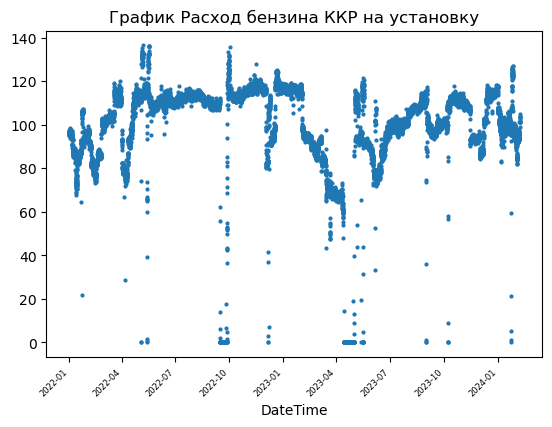

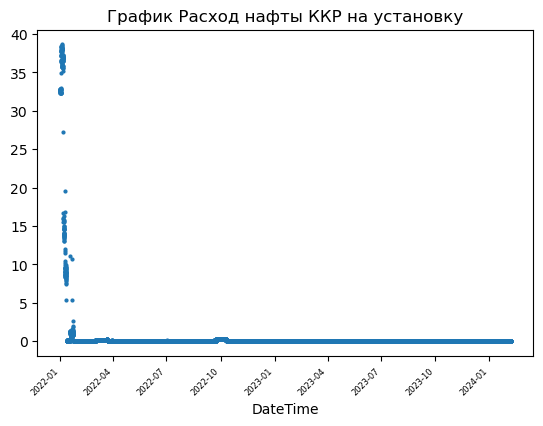

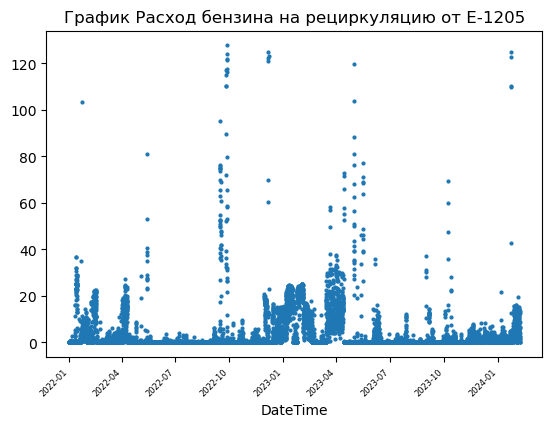

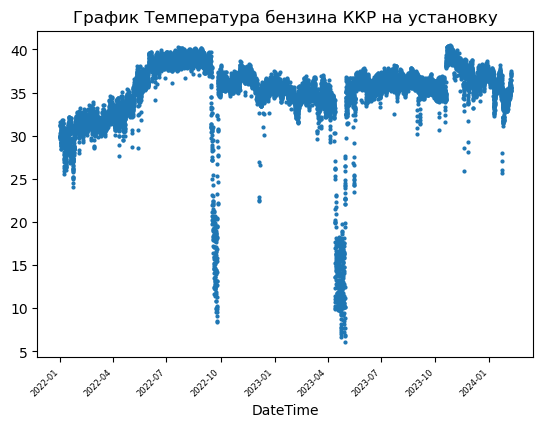

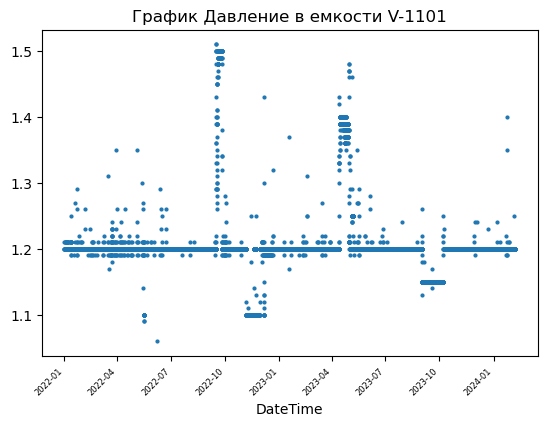

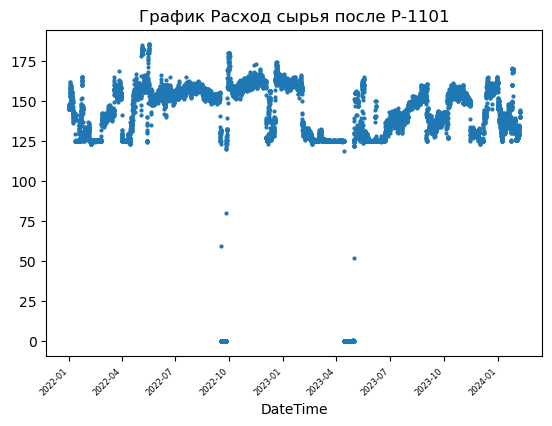

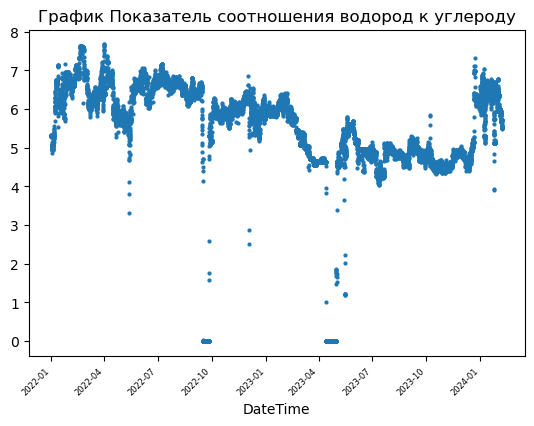

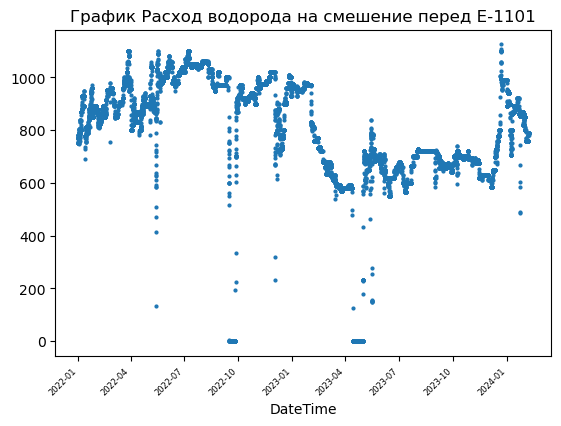

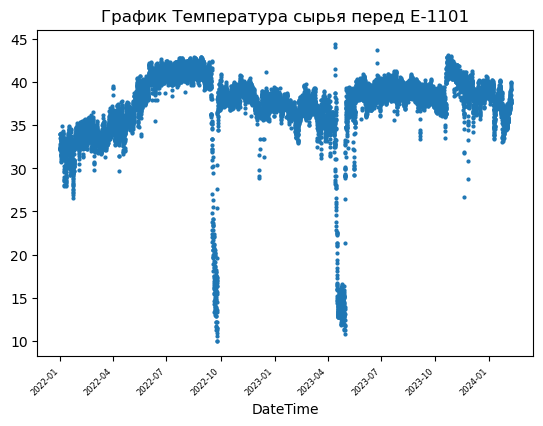

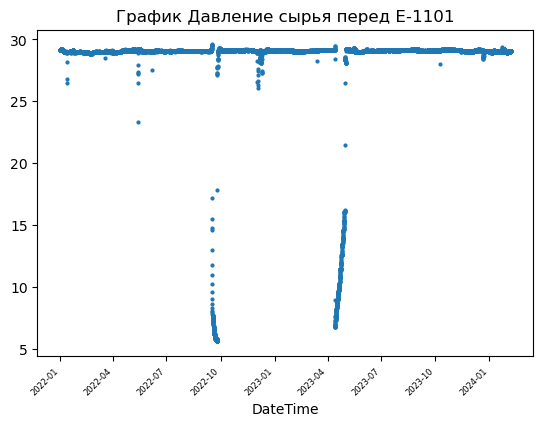

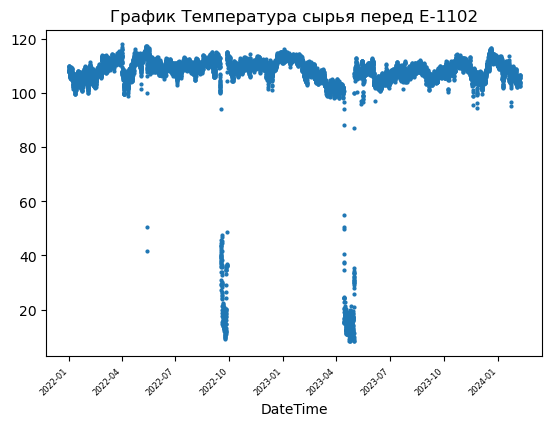

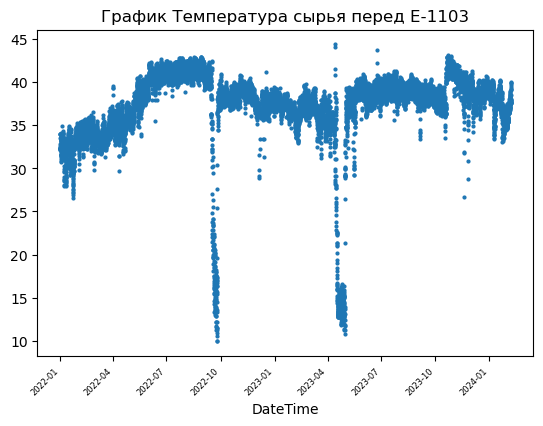

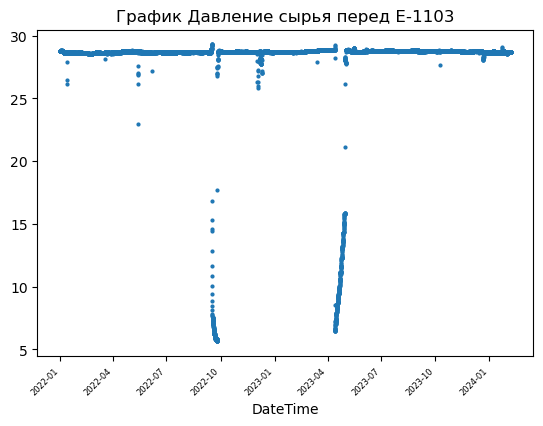

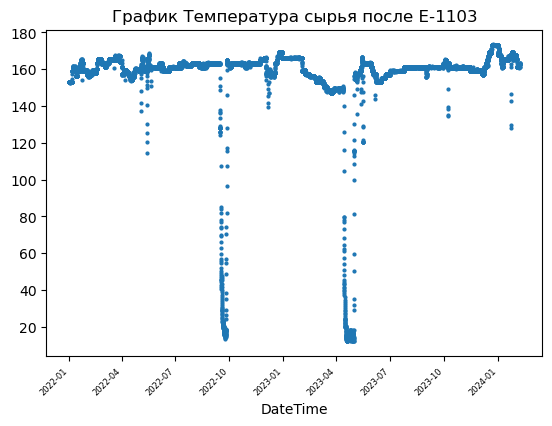

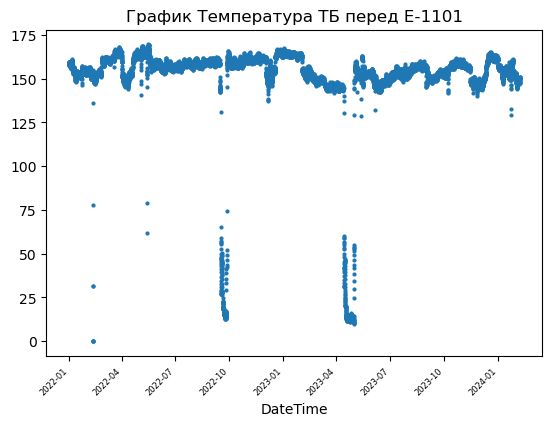

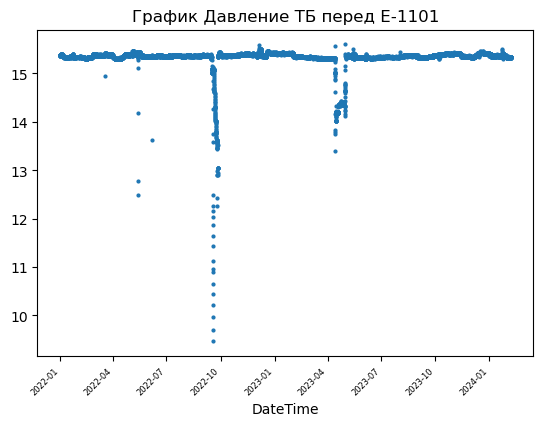

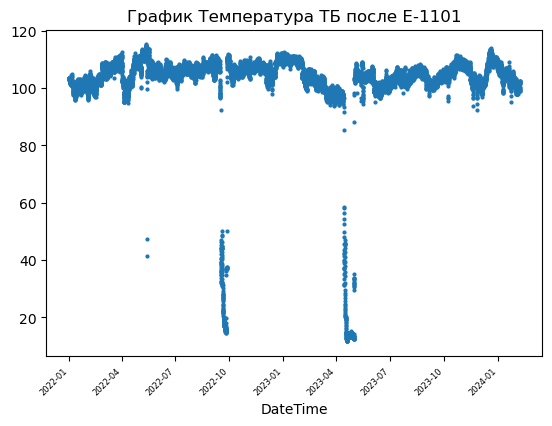

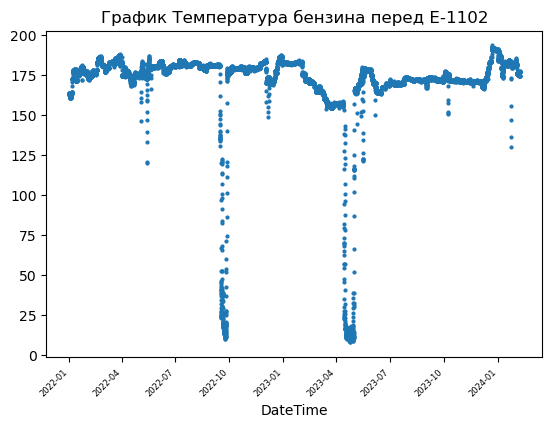

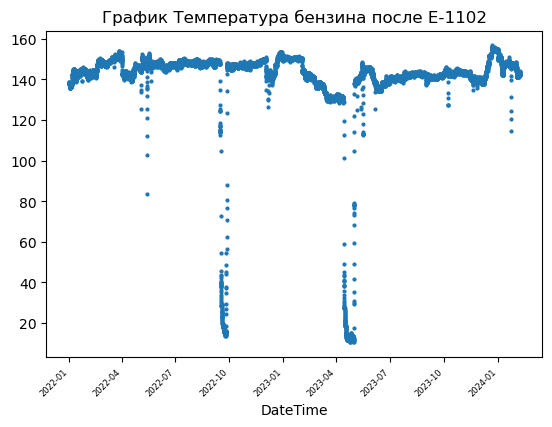

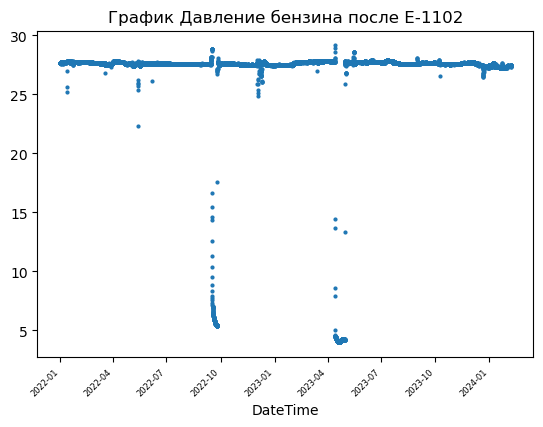

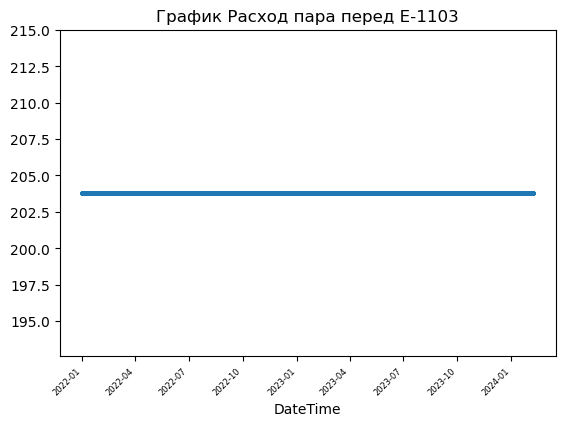

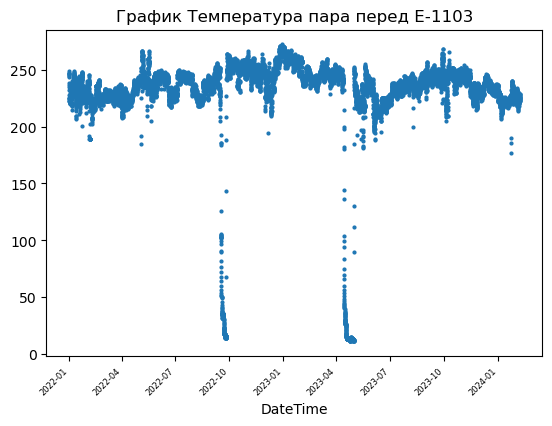

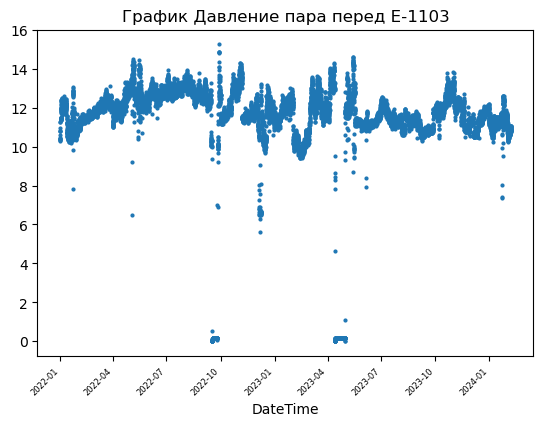

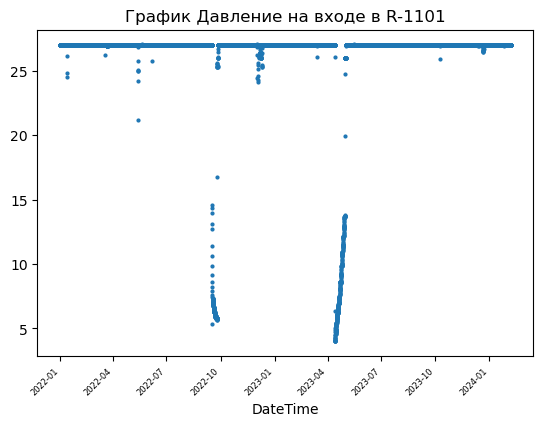

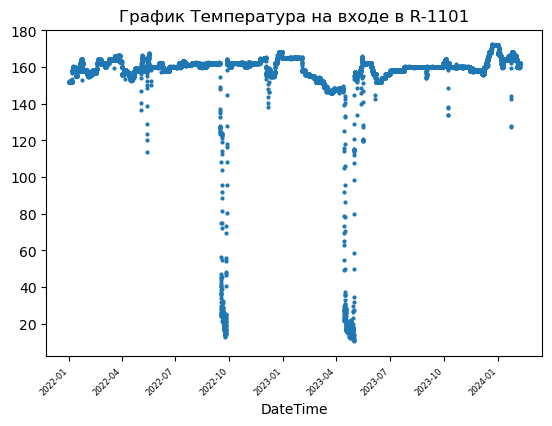

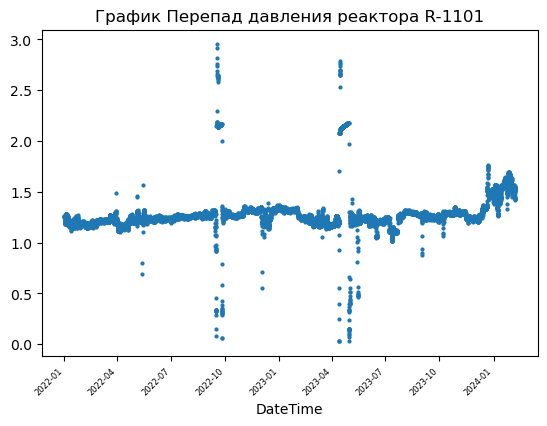

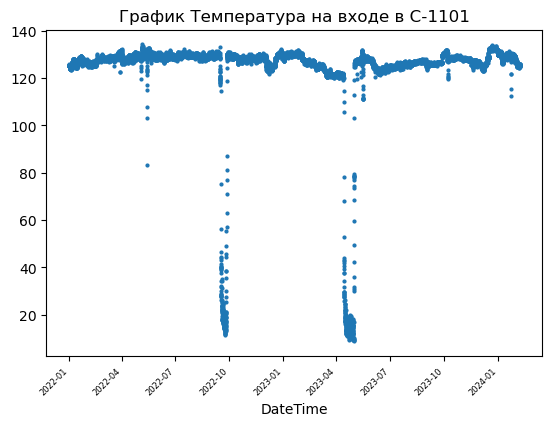

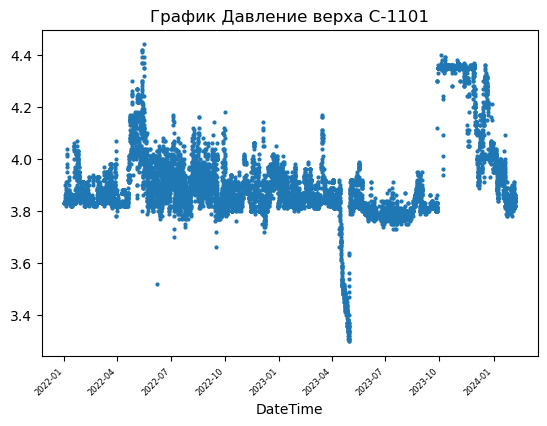

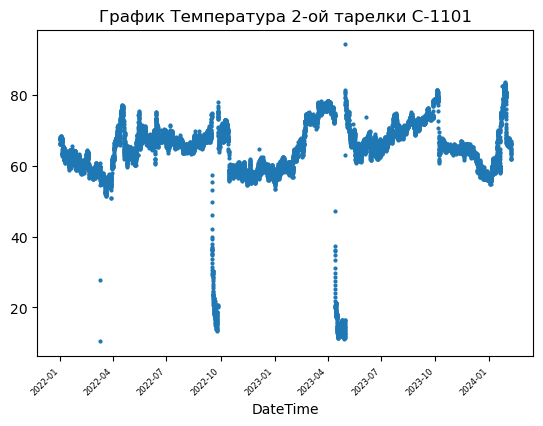

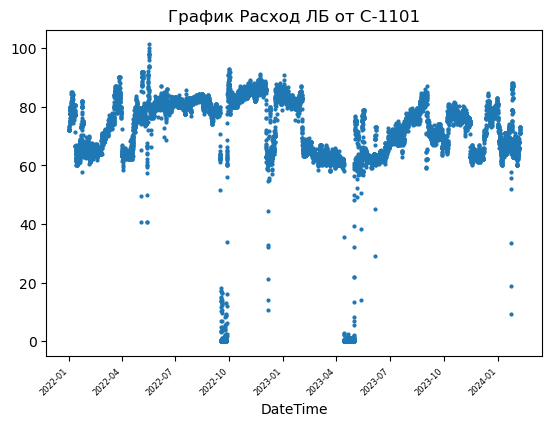

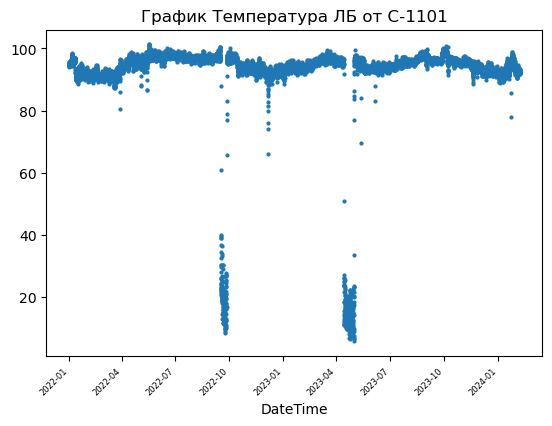

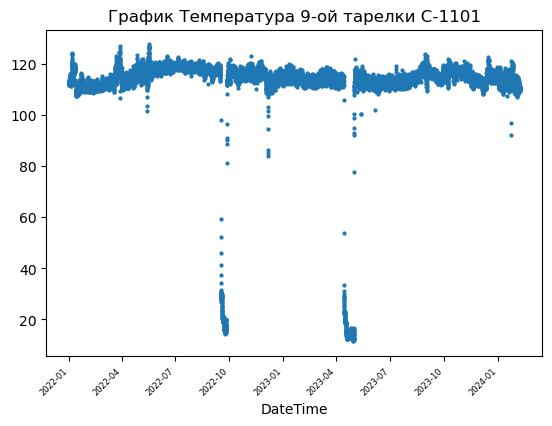

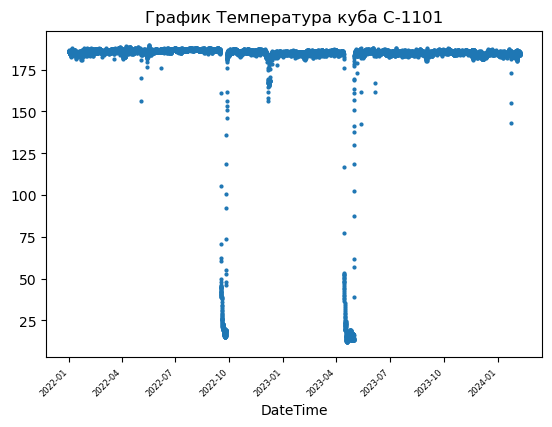

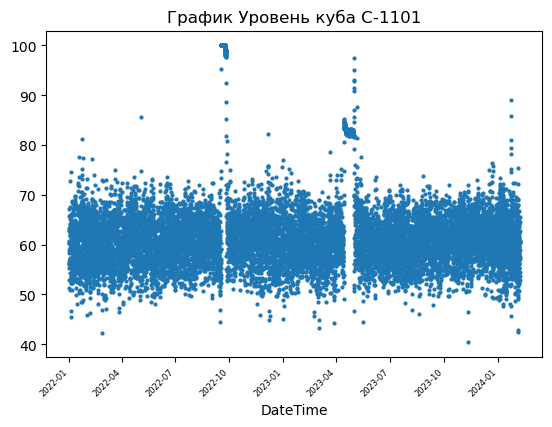

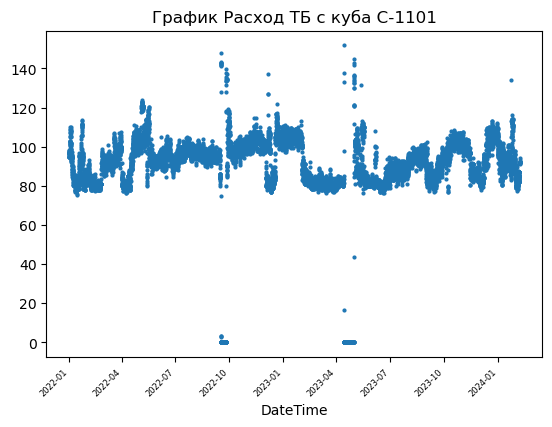

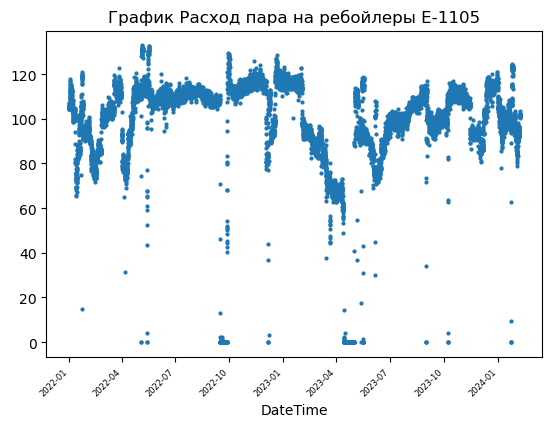

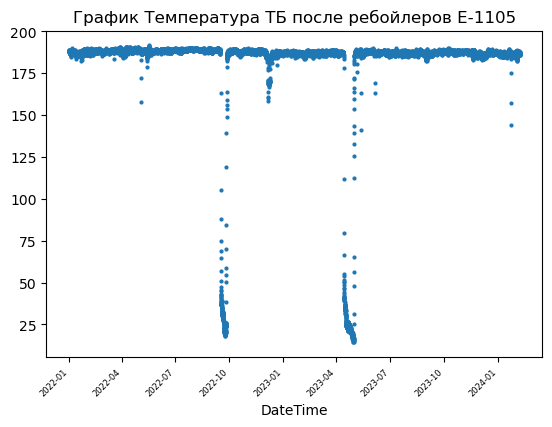

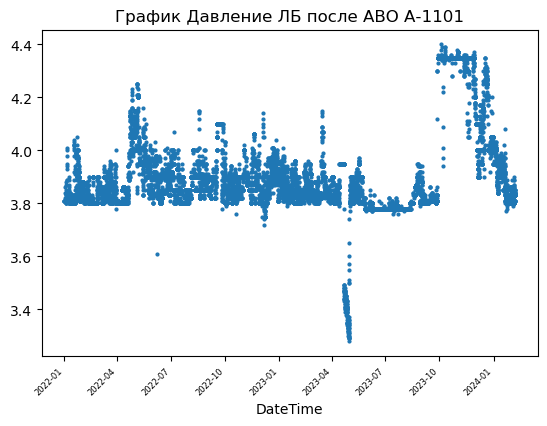

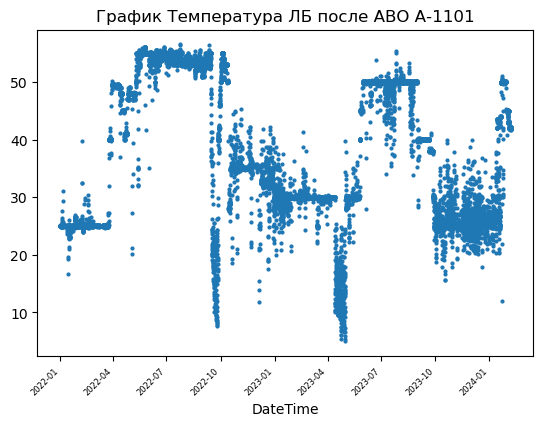

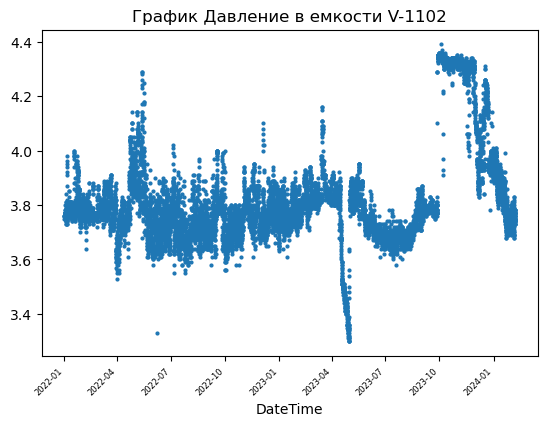

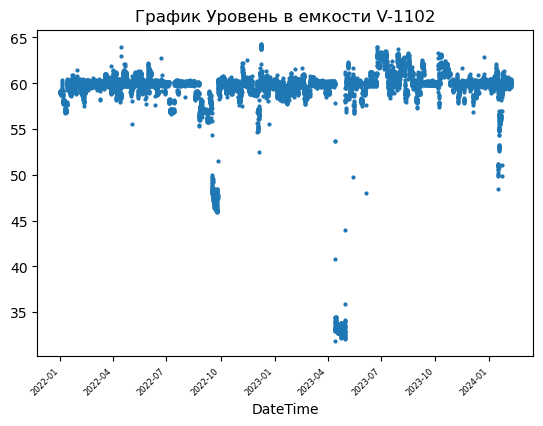

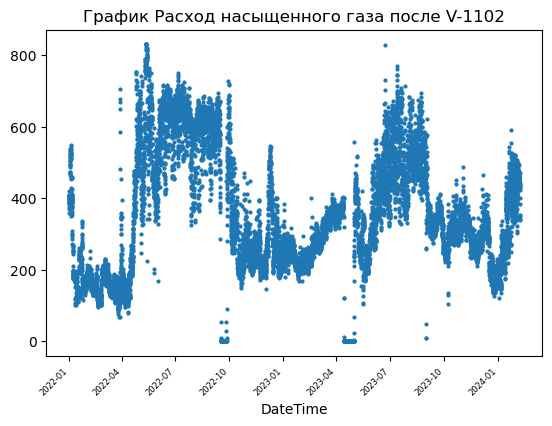

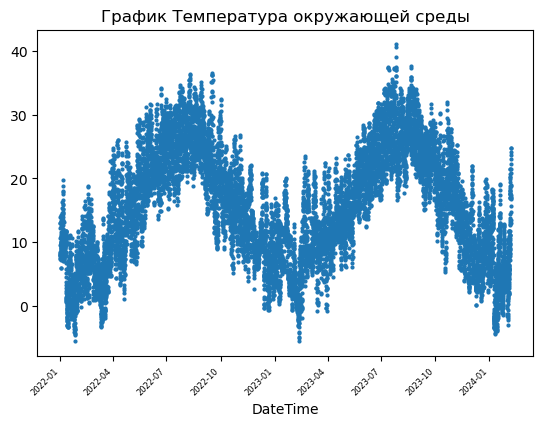

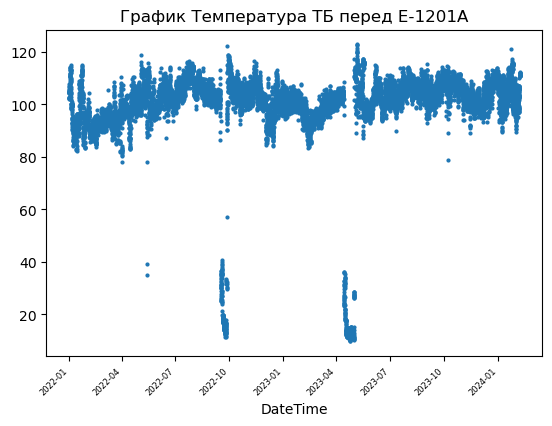

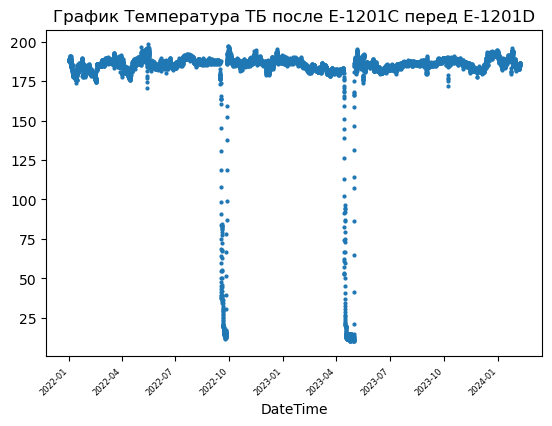

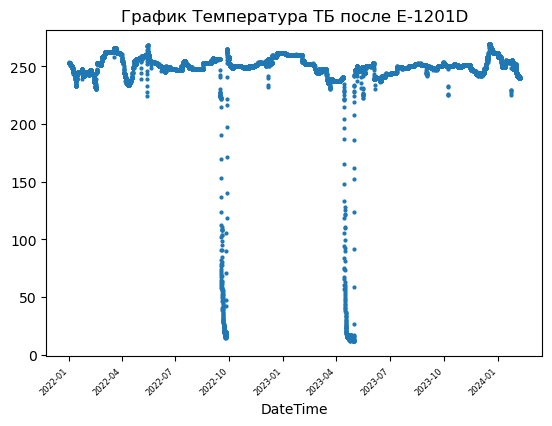

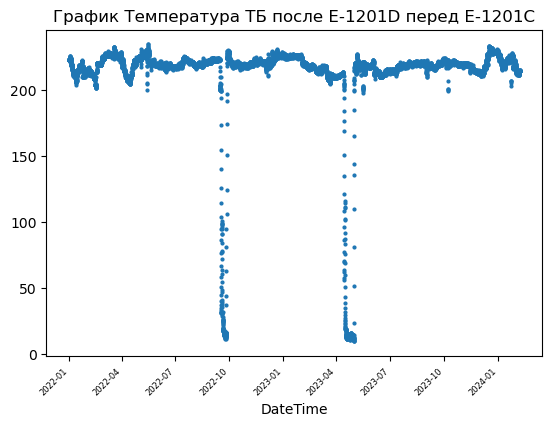

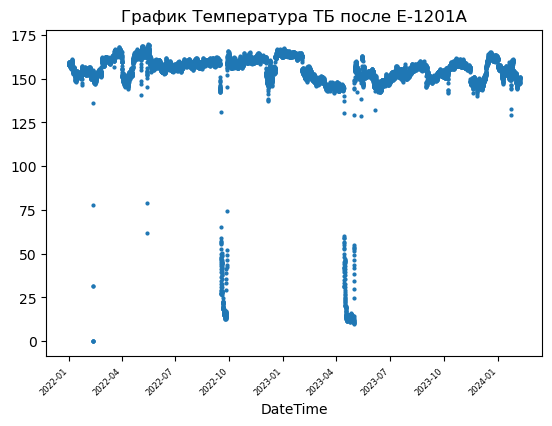

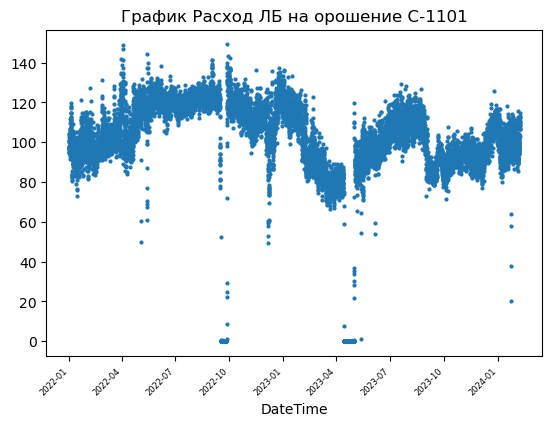

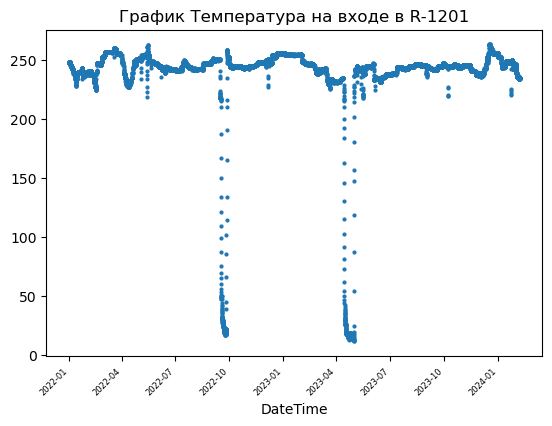

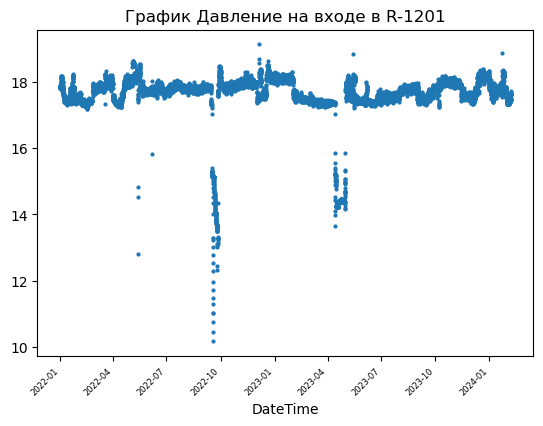

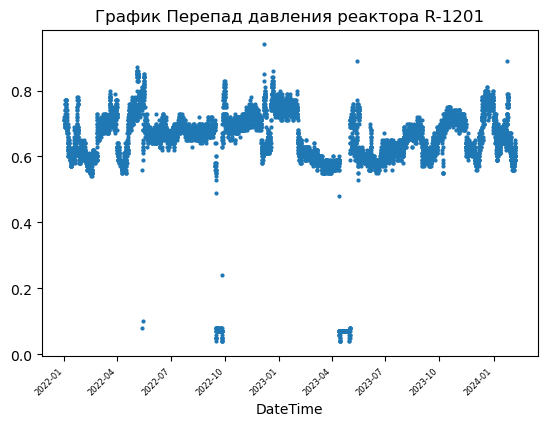

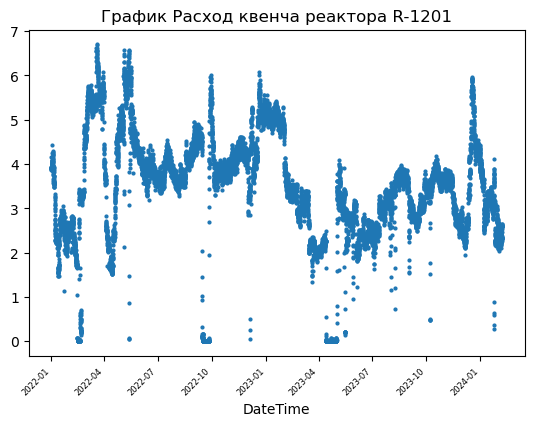

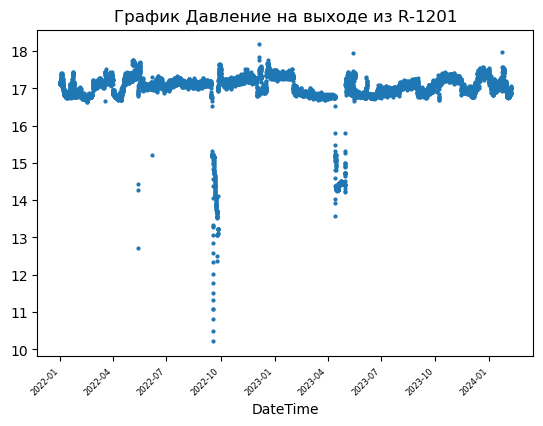

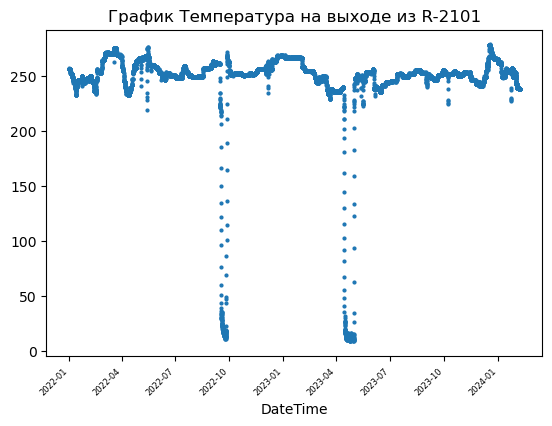

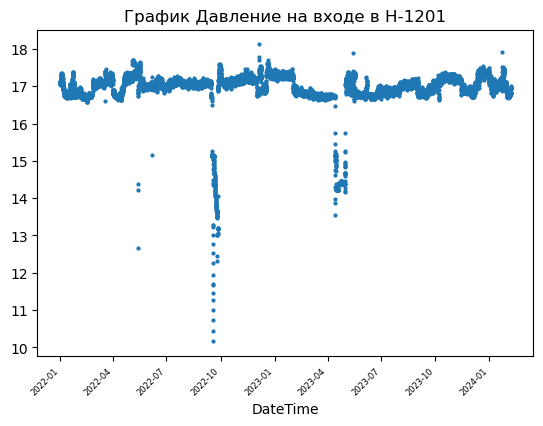

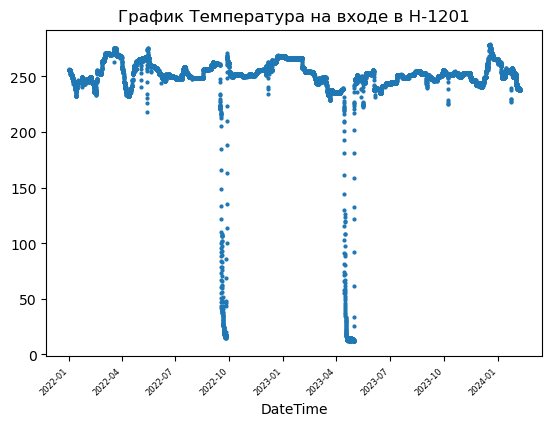

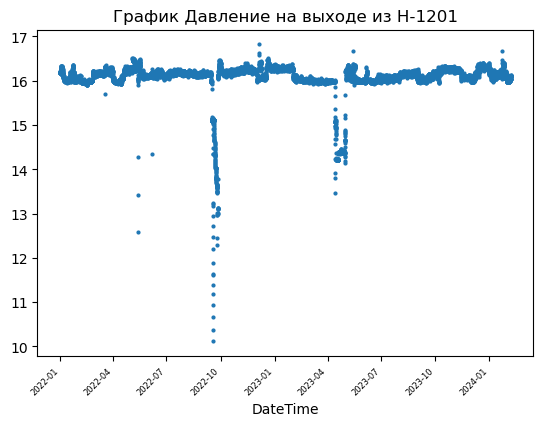

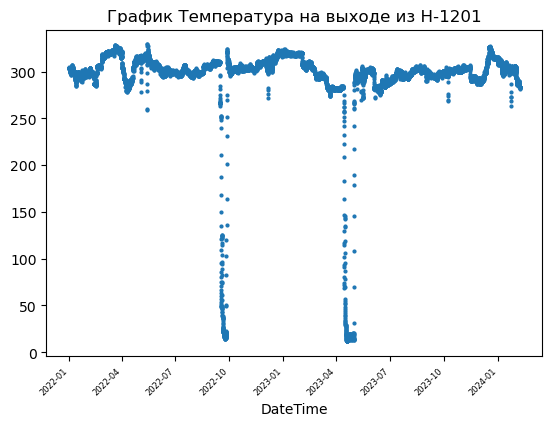

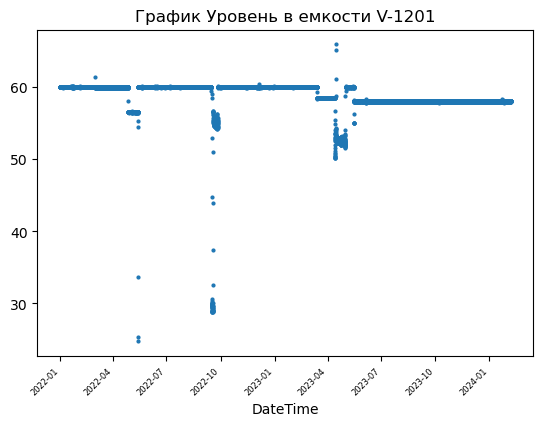

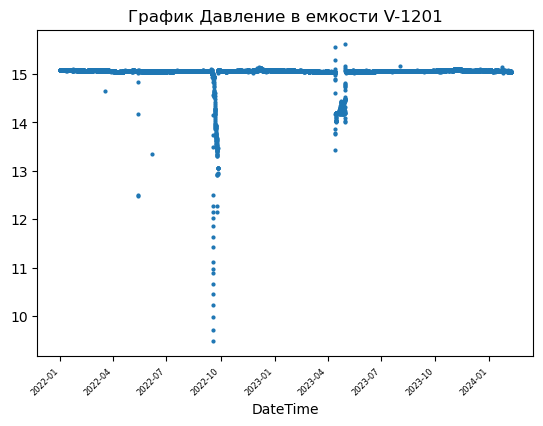

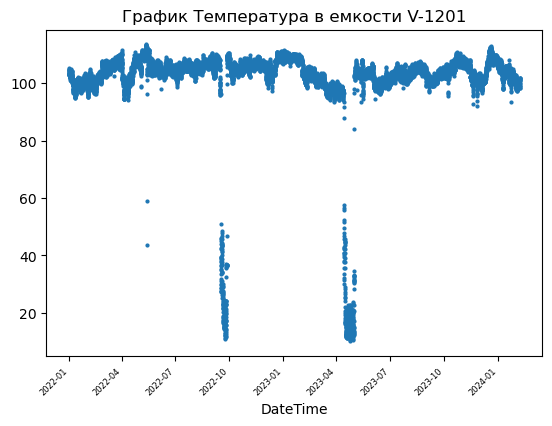

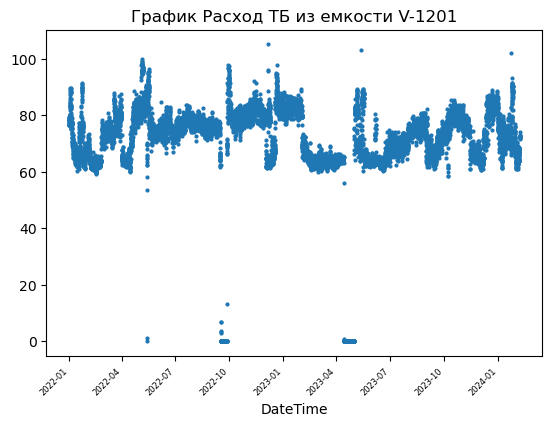

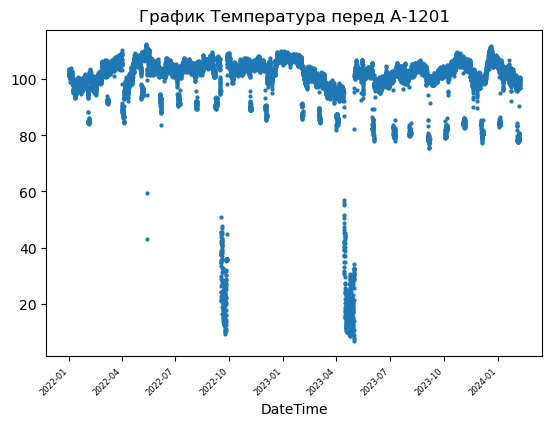

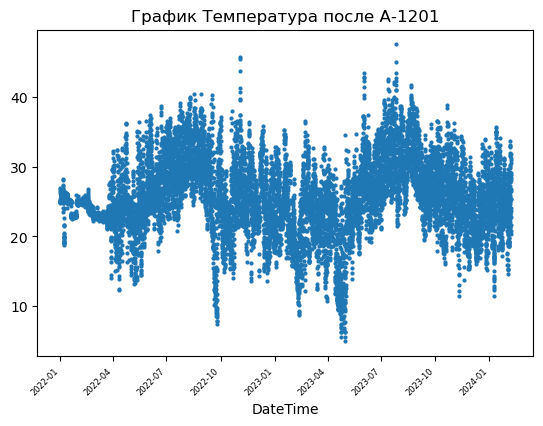

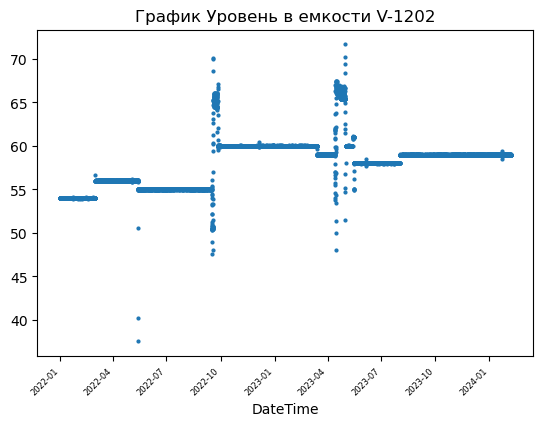

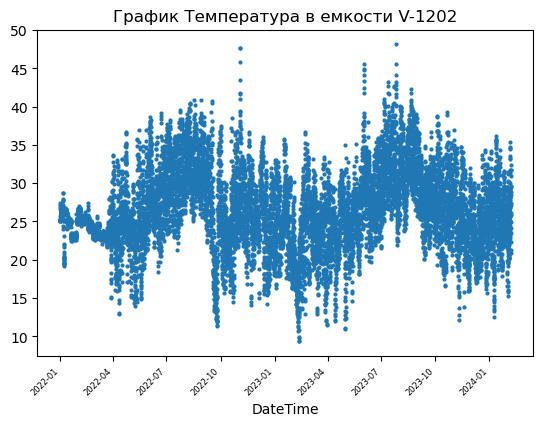

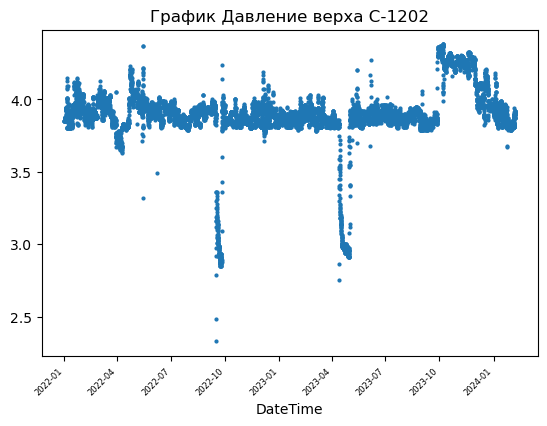

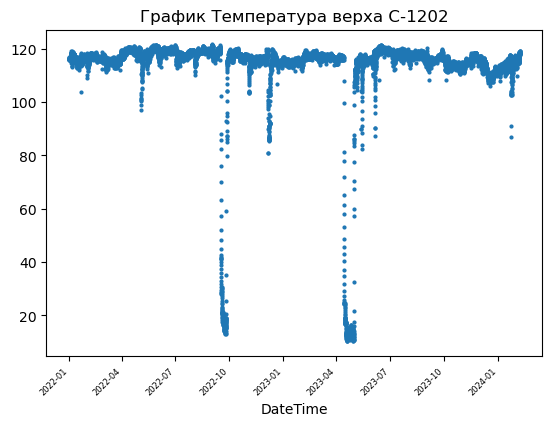

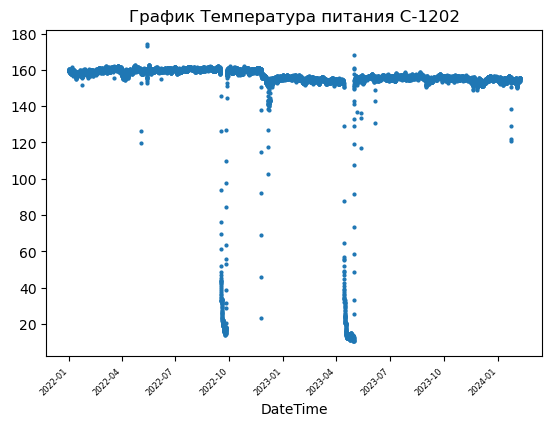

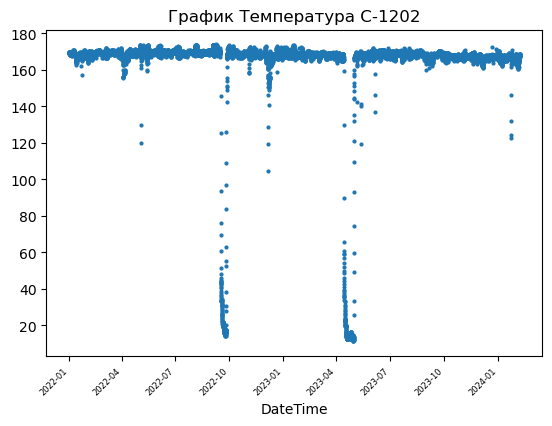

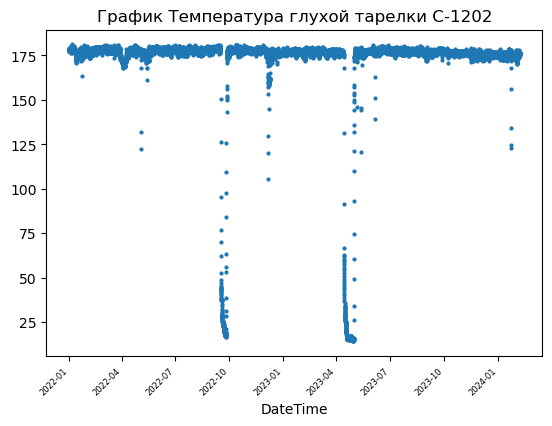

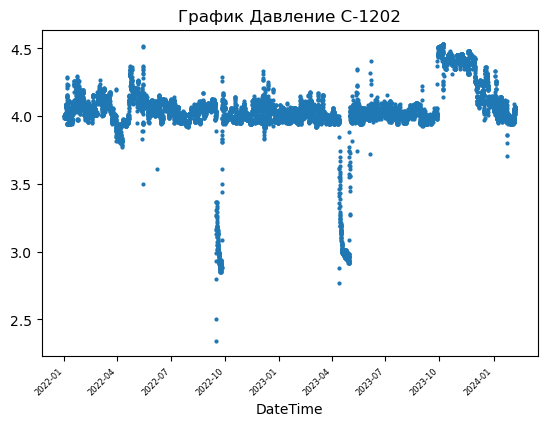

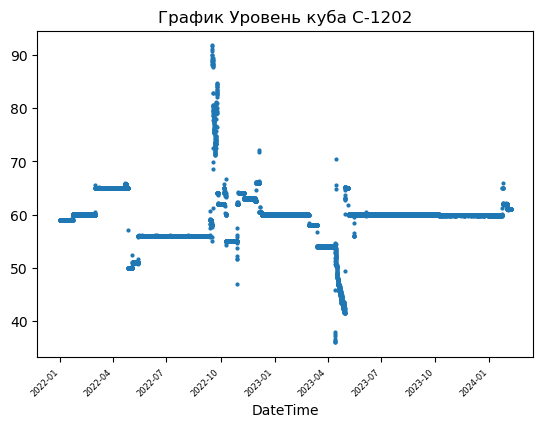

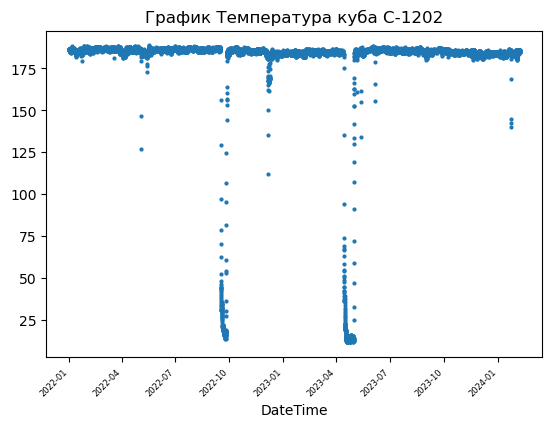

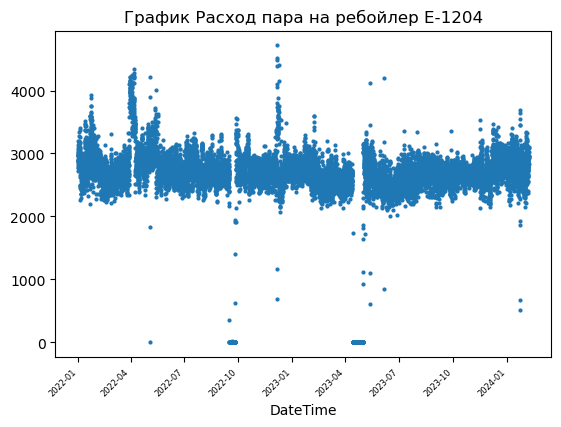

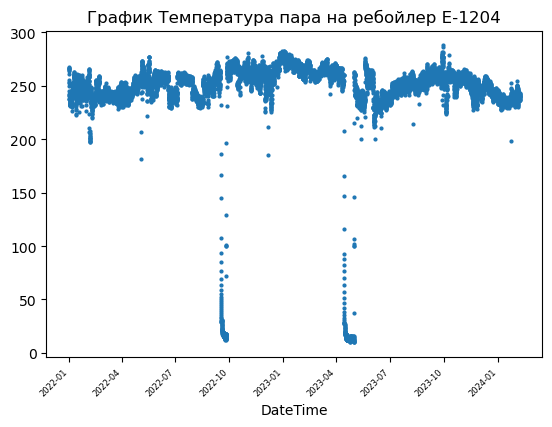

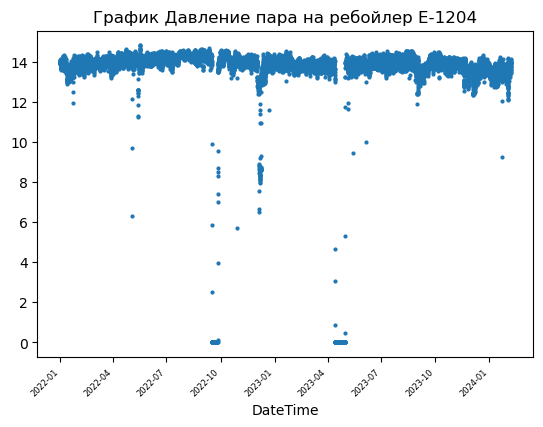

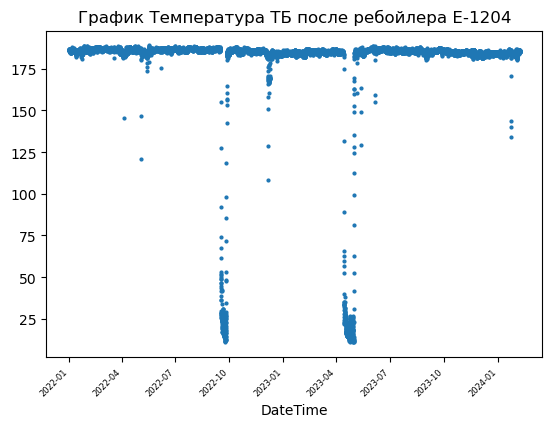

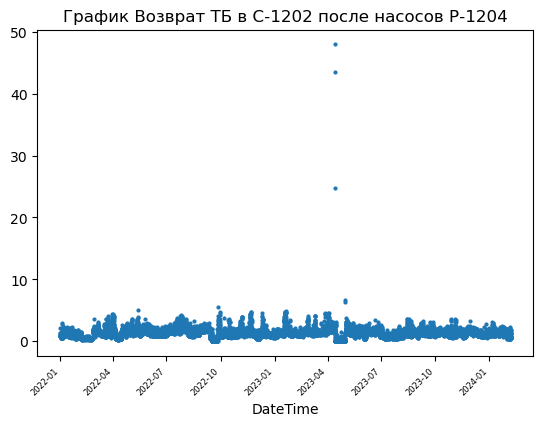

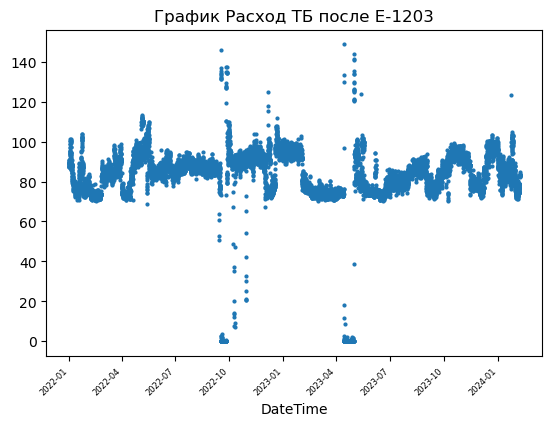

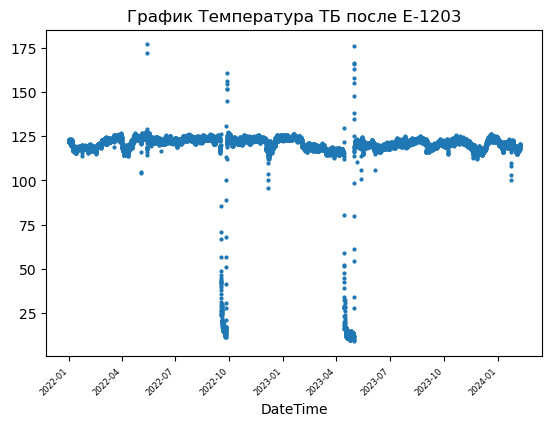

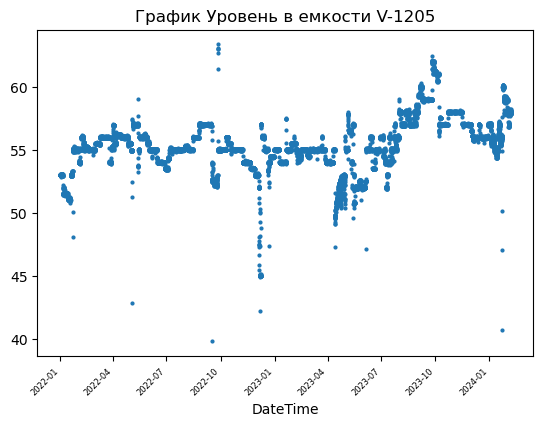

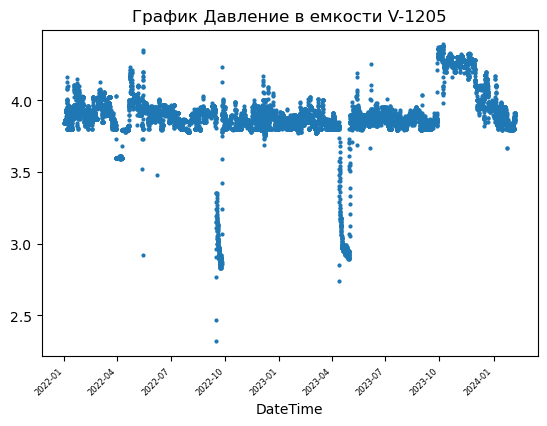

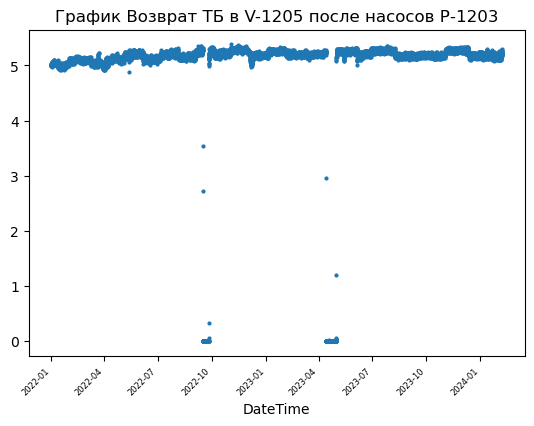

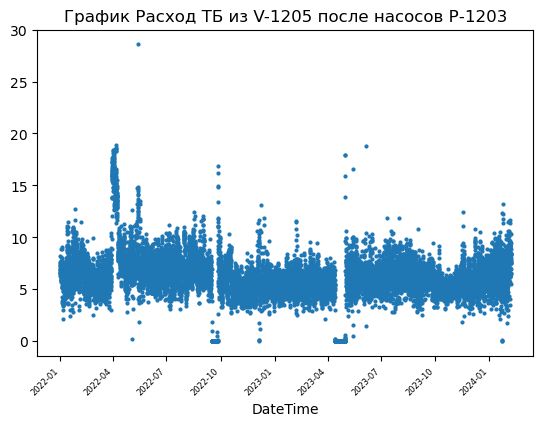

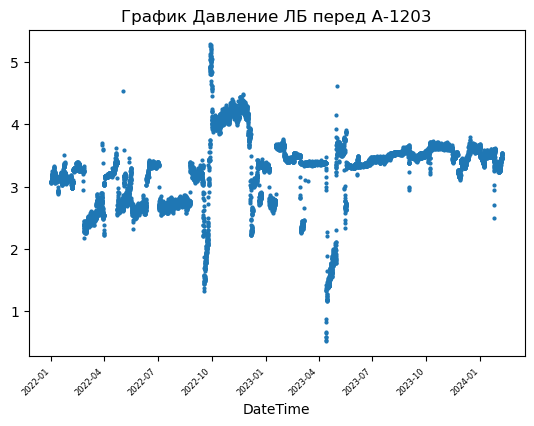

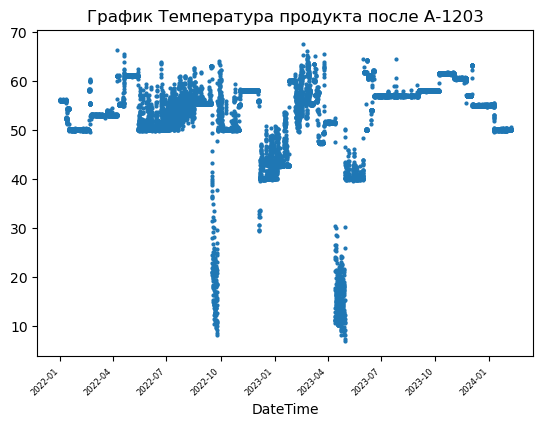

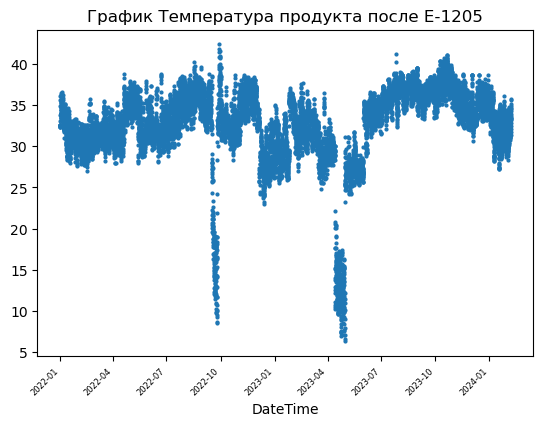

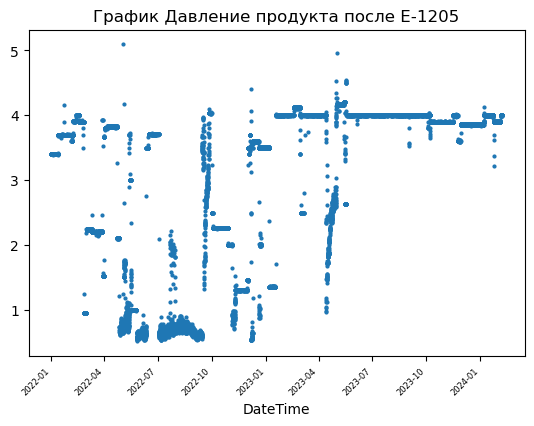

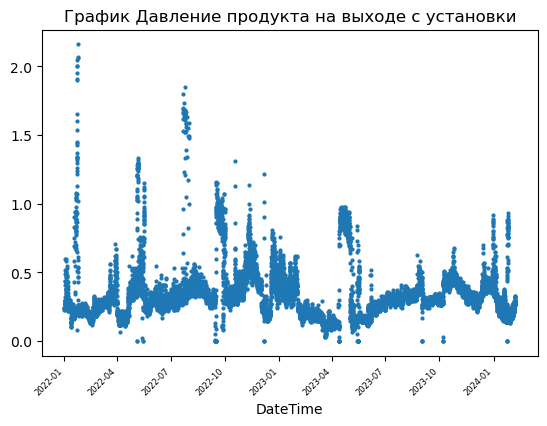

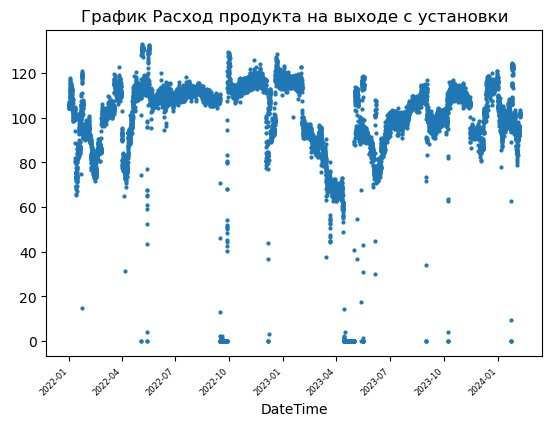

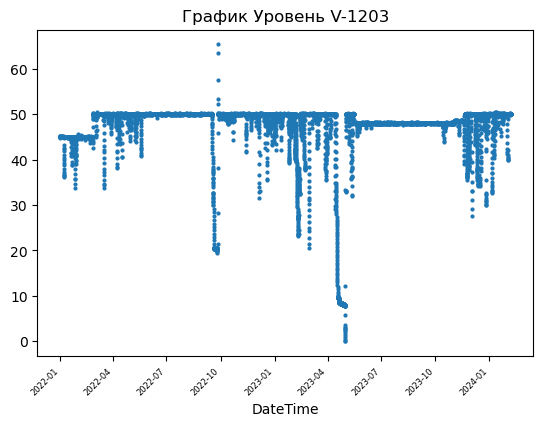

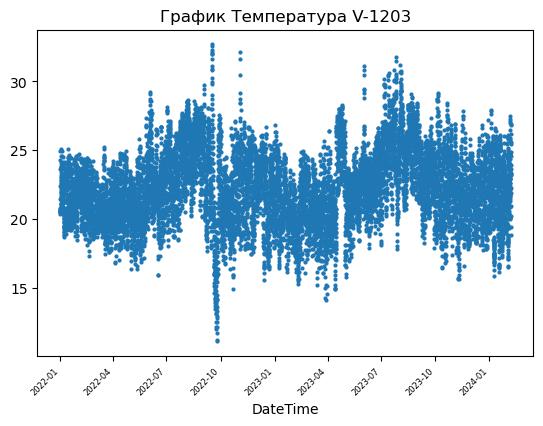

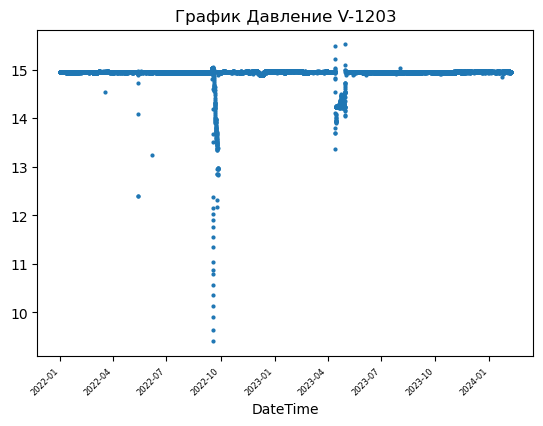

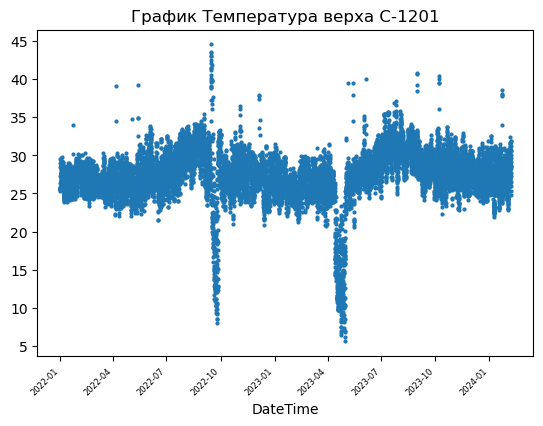

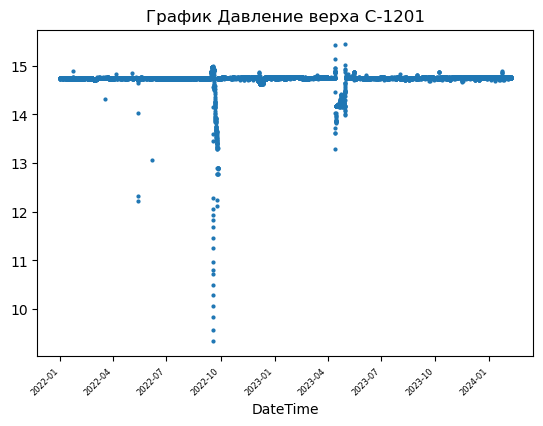

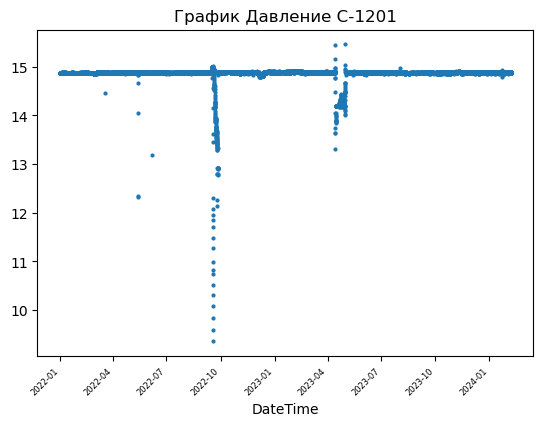

In [15]:
parameter_vis(df_X1)

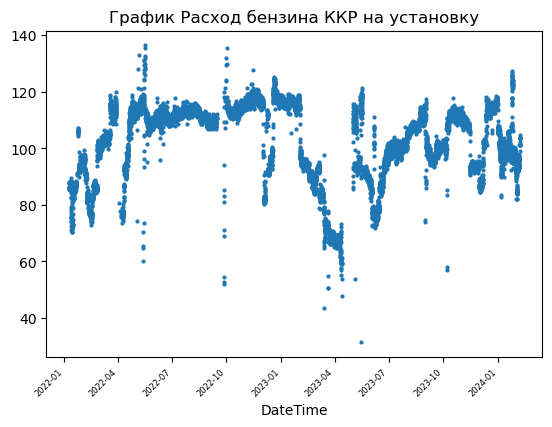

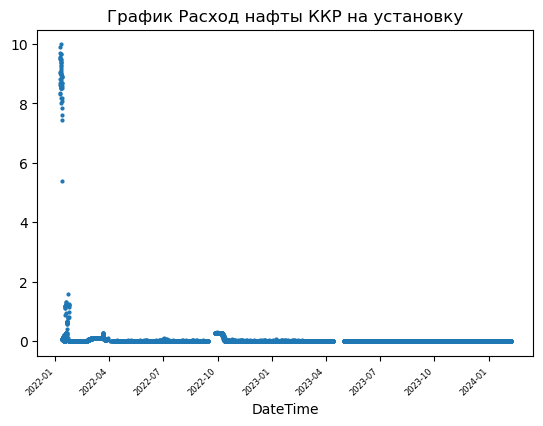

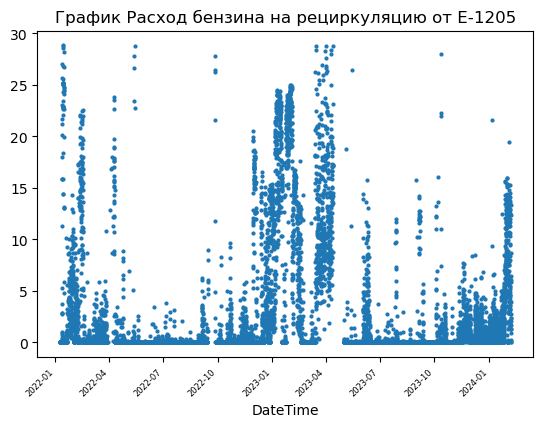

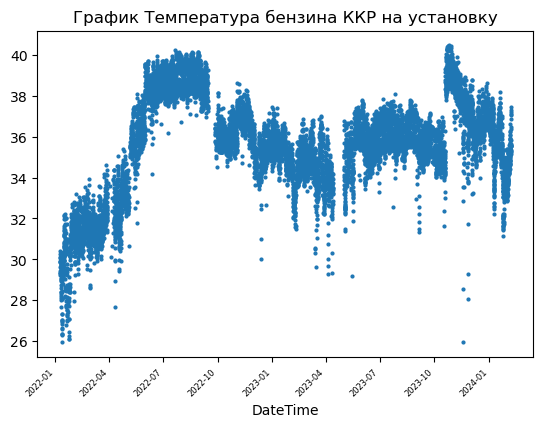

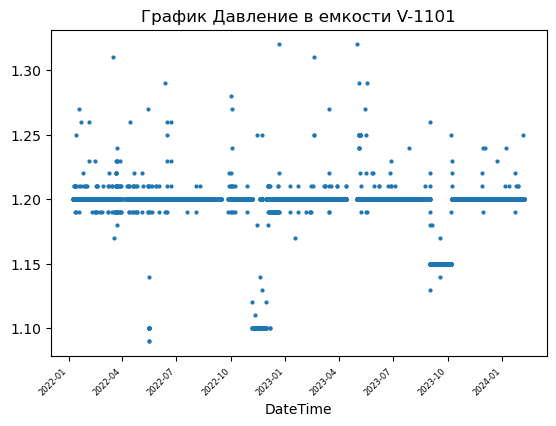

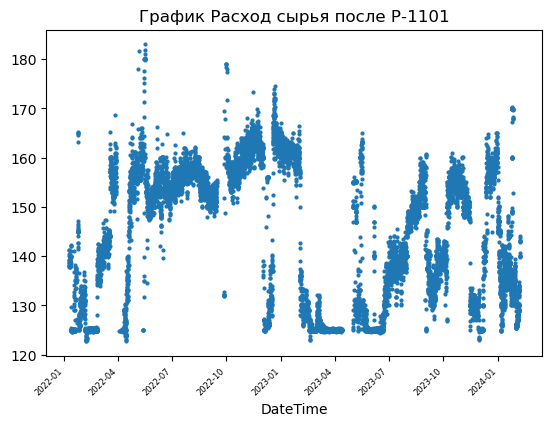

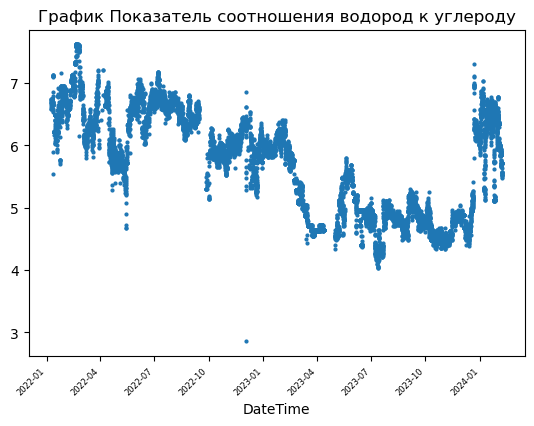

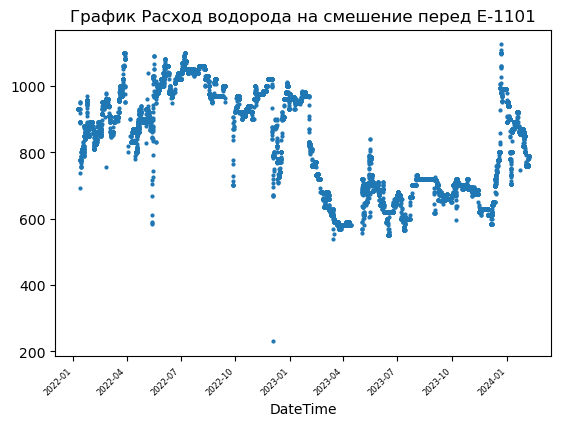

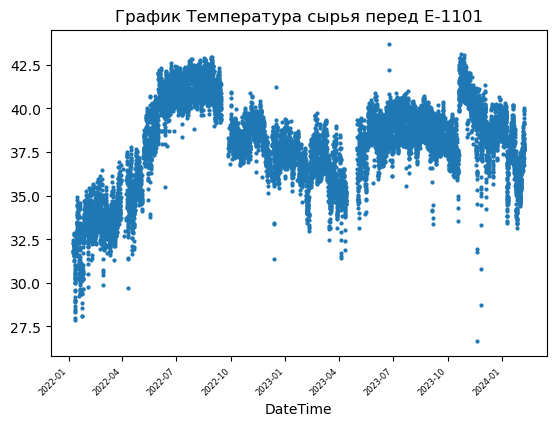

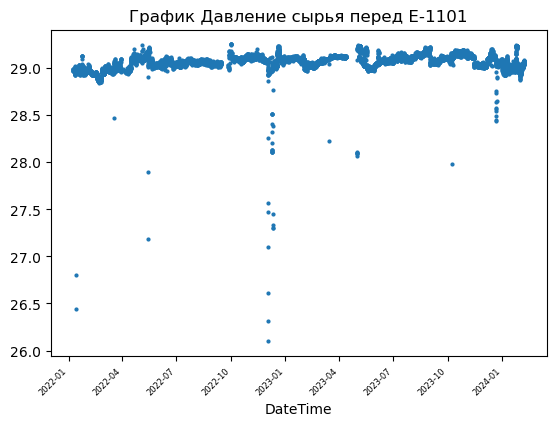

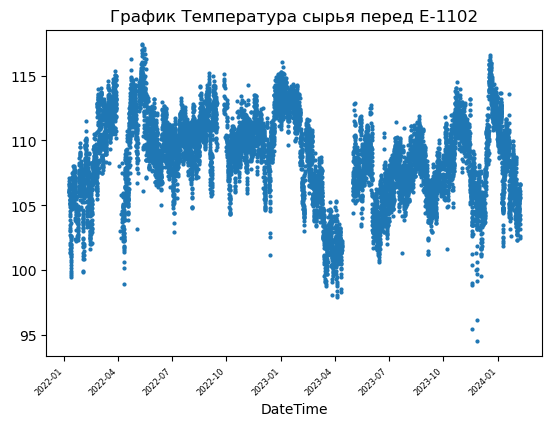

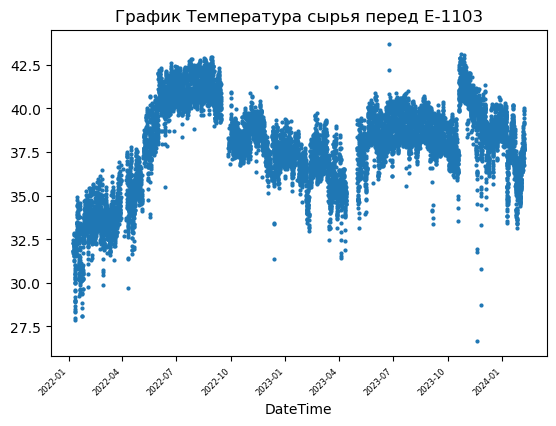

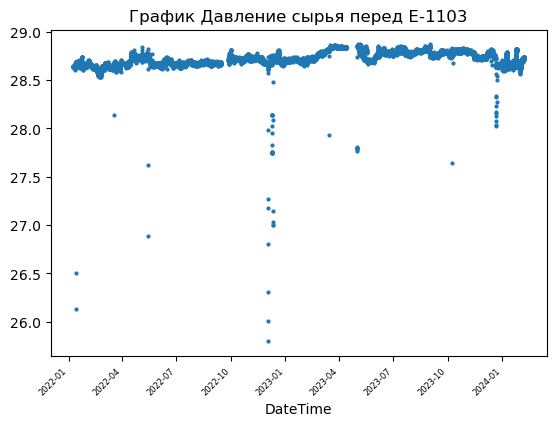

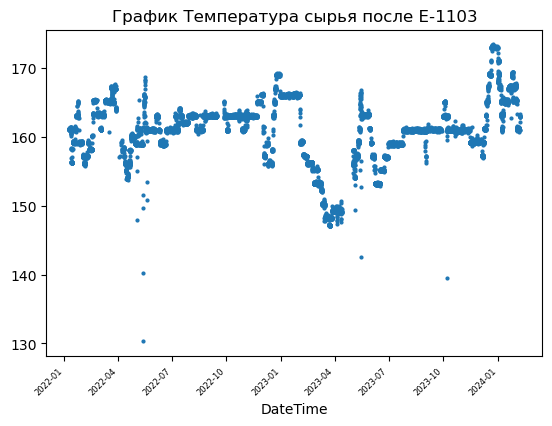

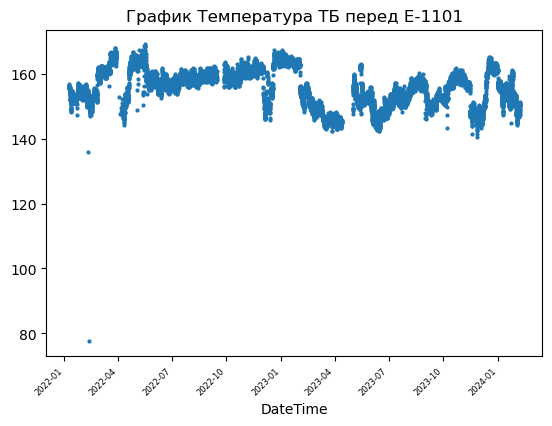

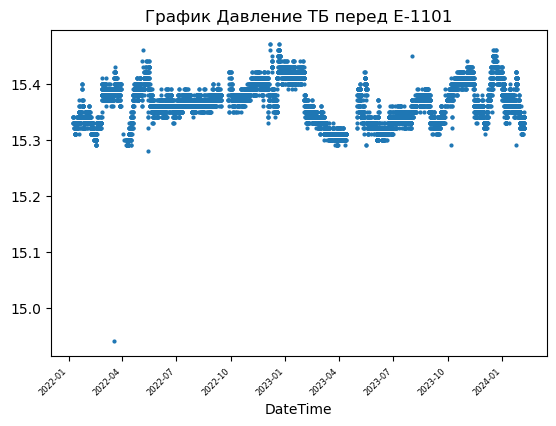

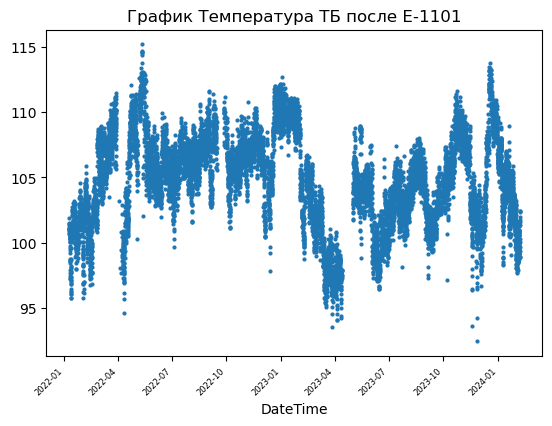

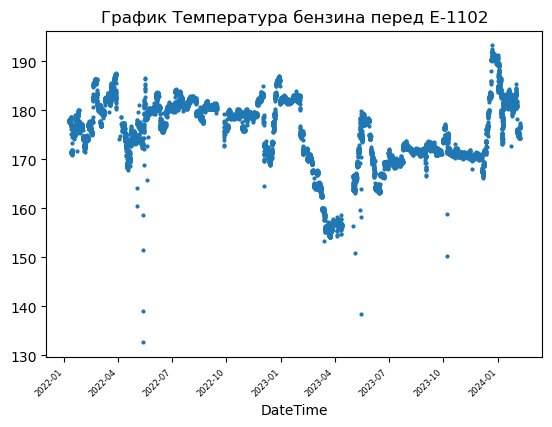

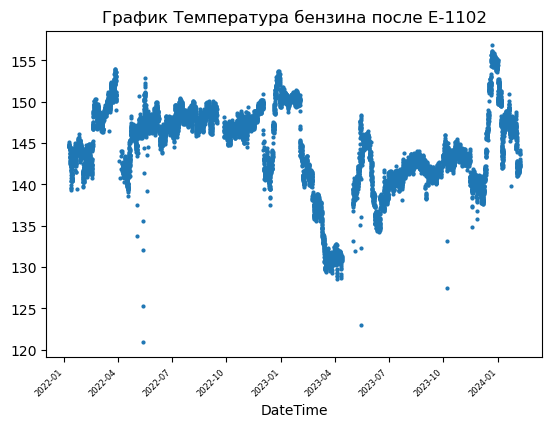

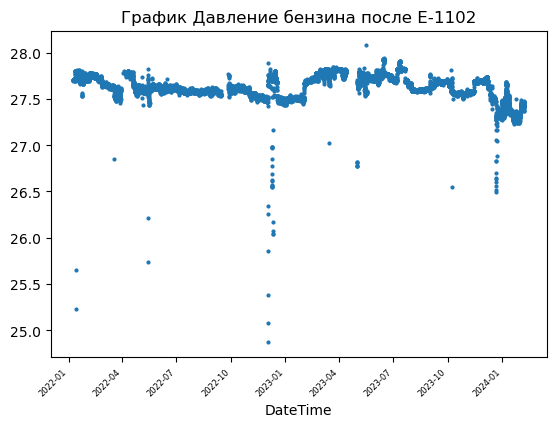

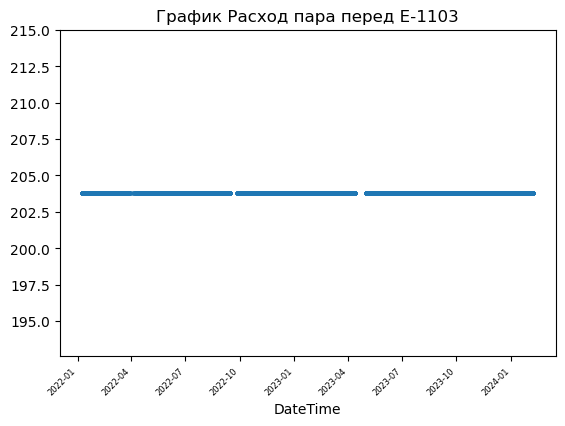

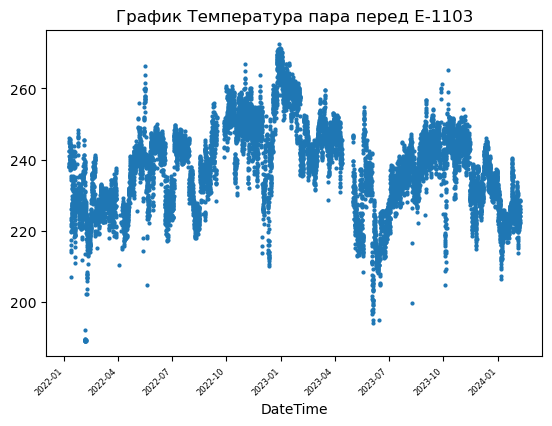

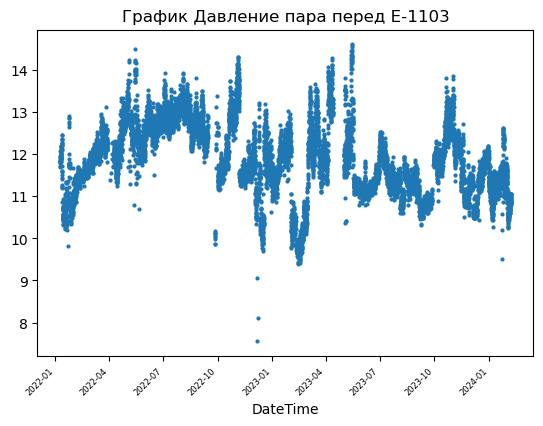

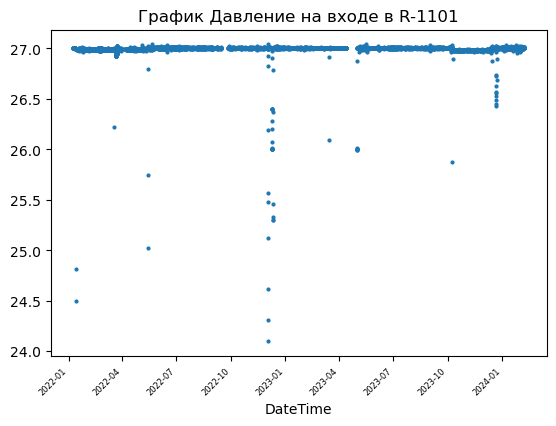

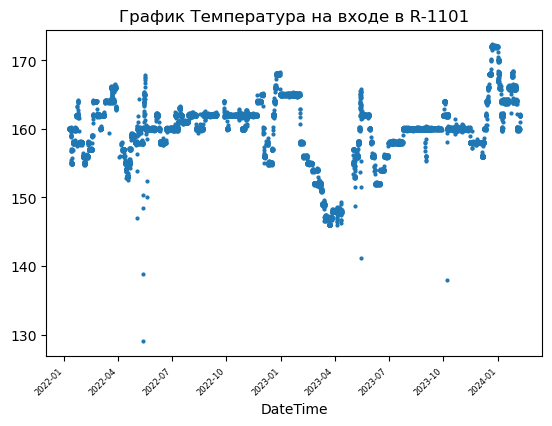

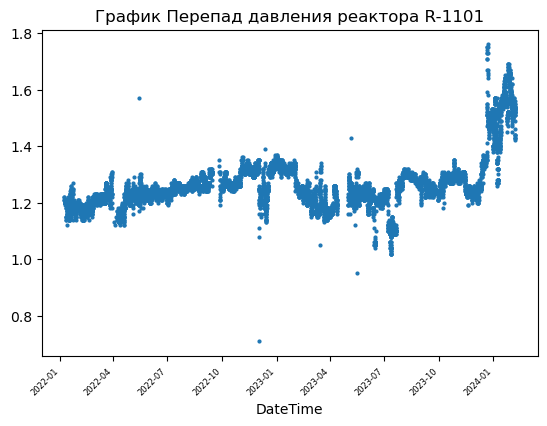

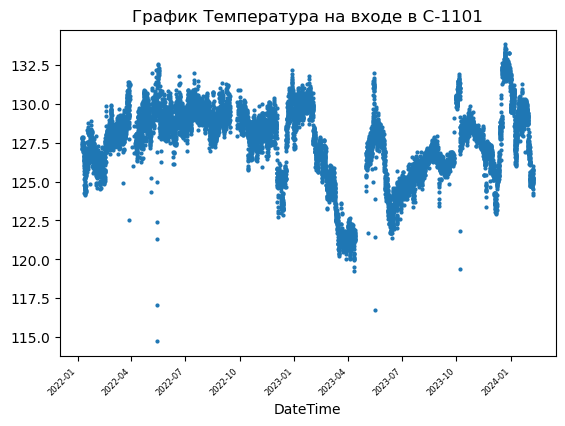

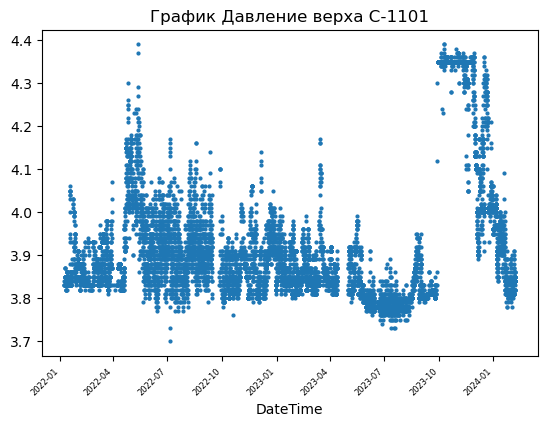

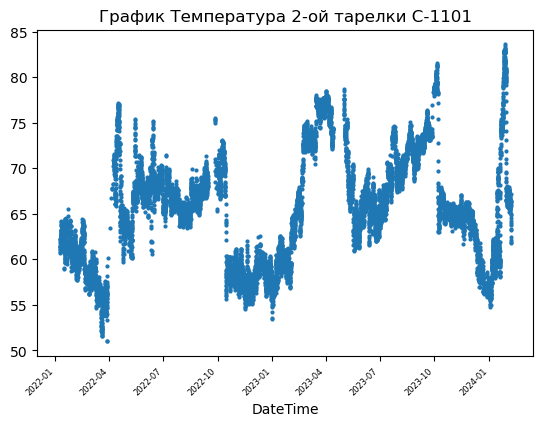

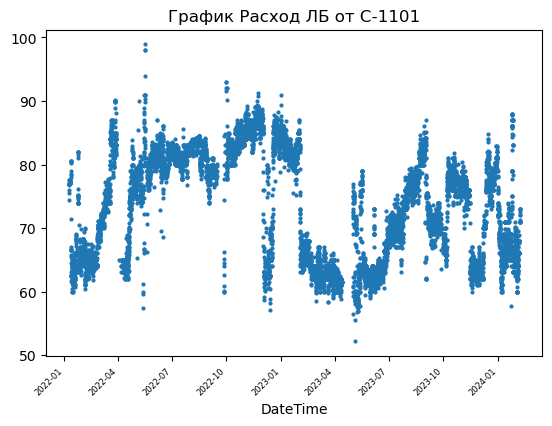

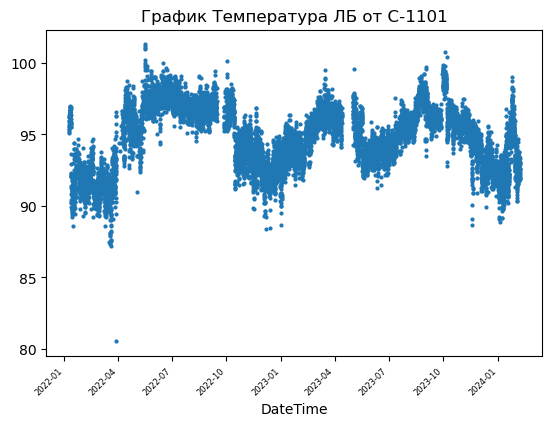

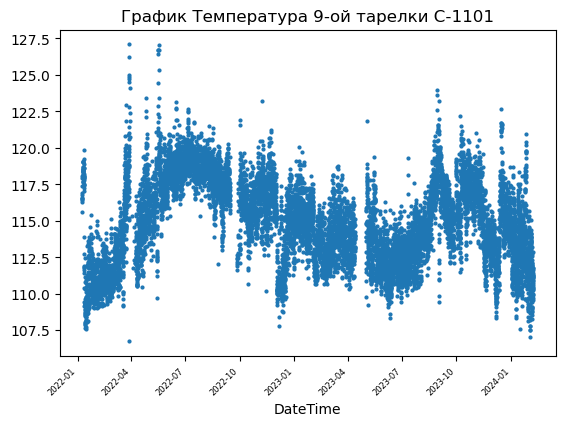

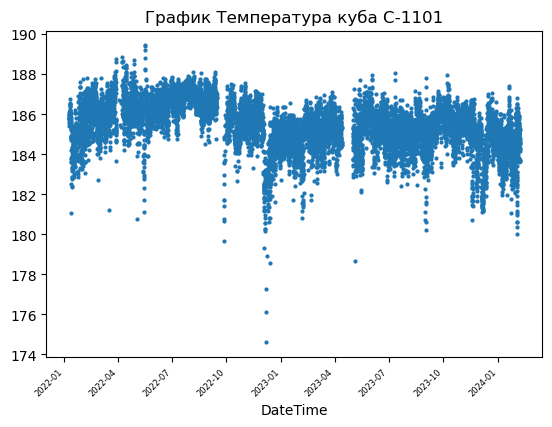

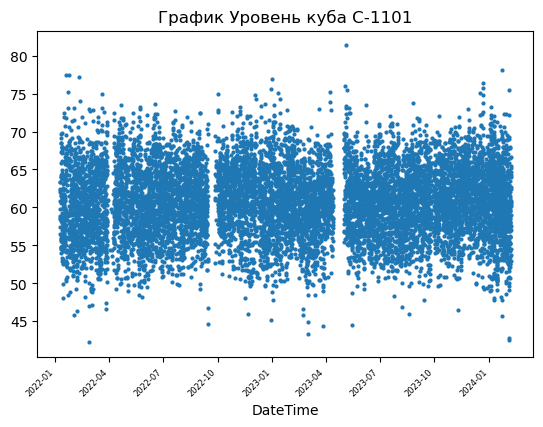

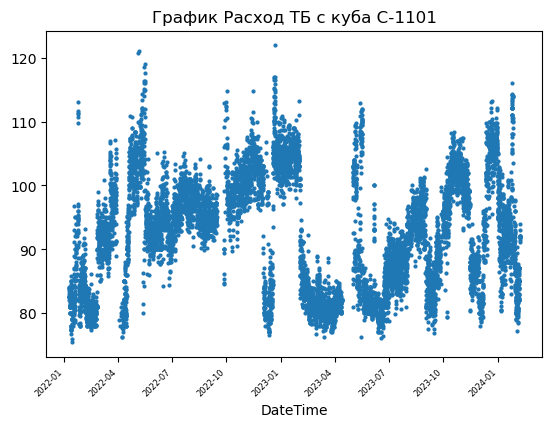

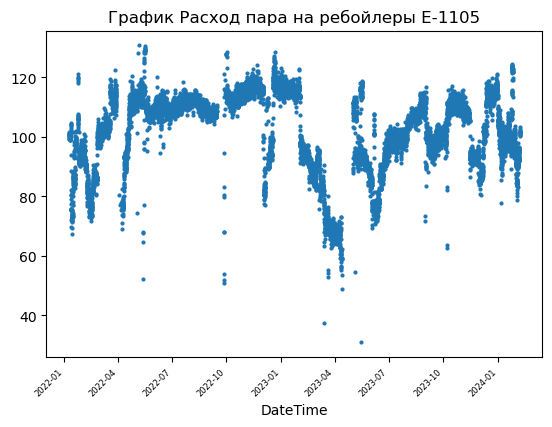

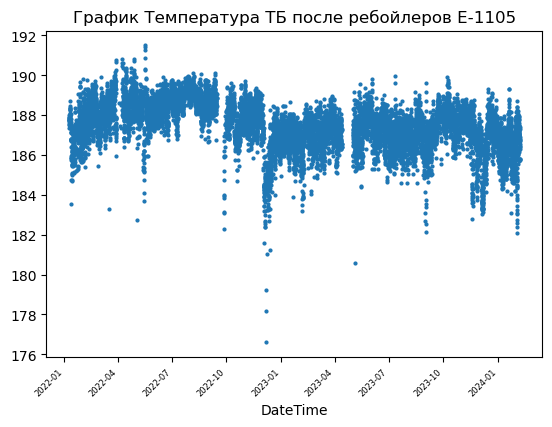

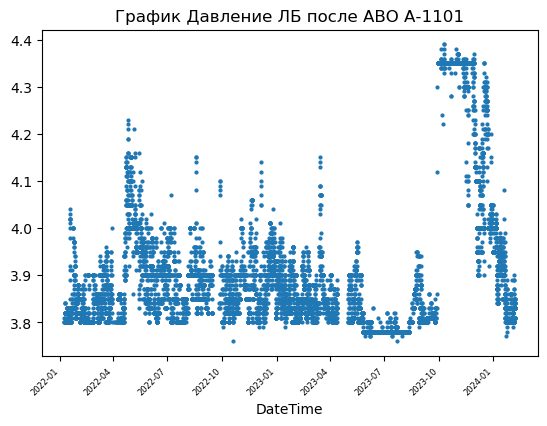

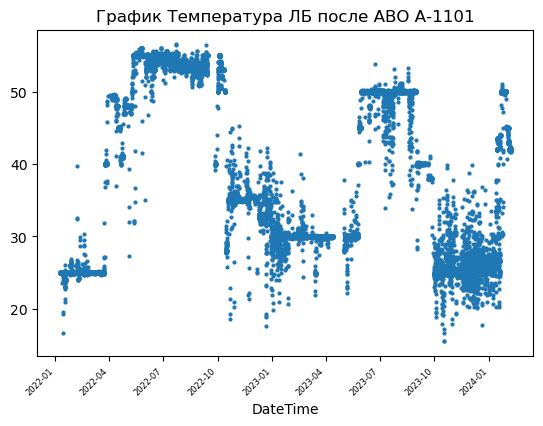

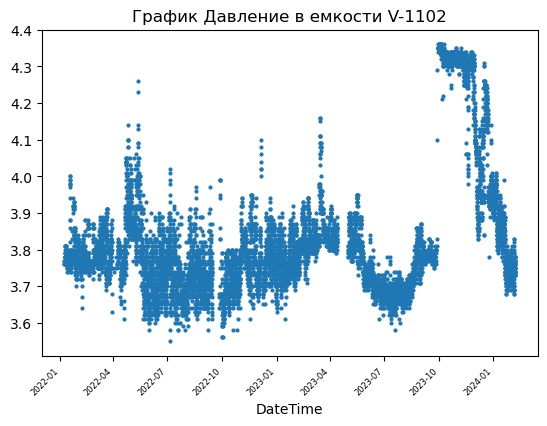

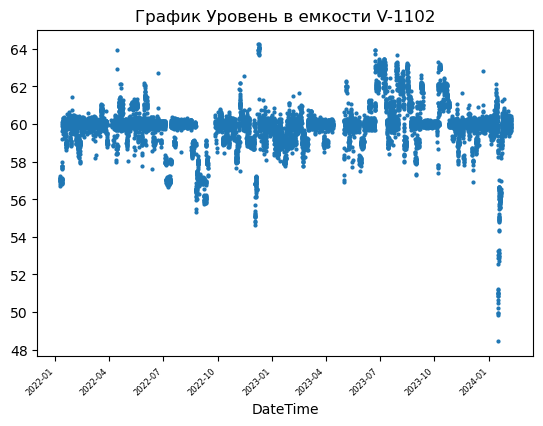

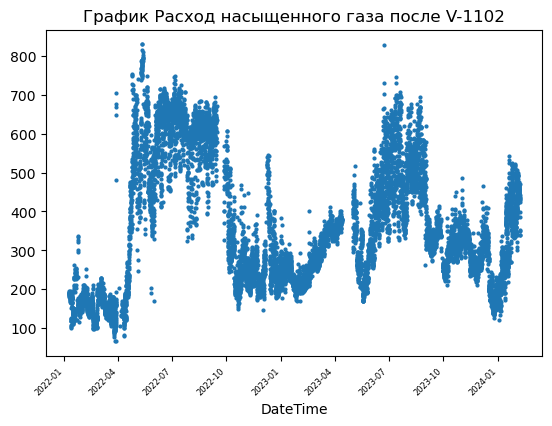

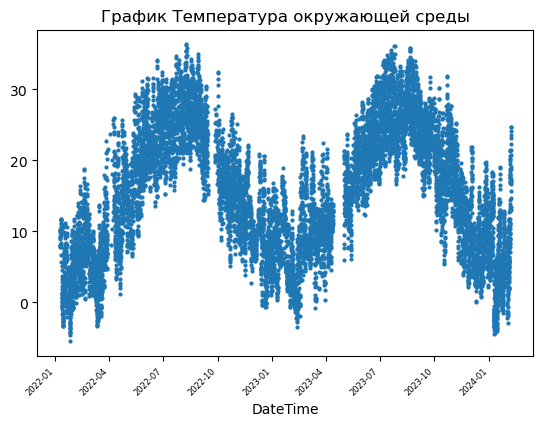

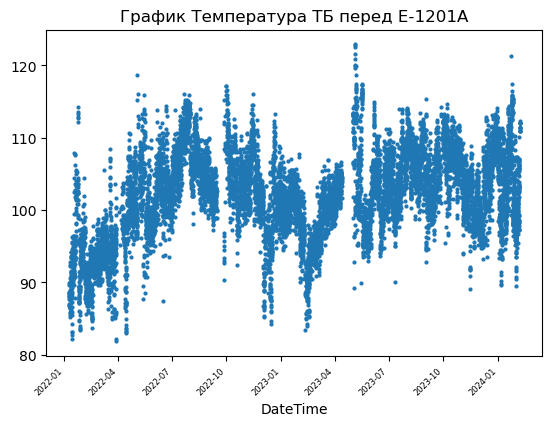

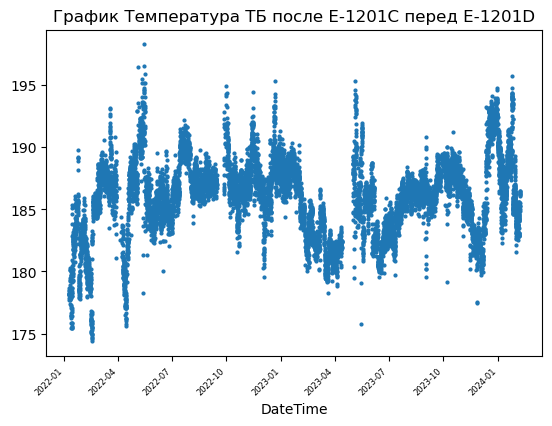

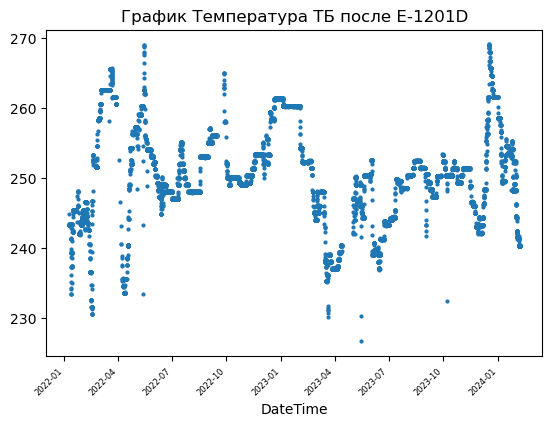

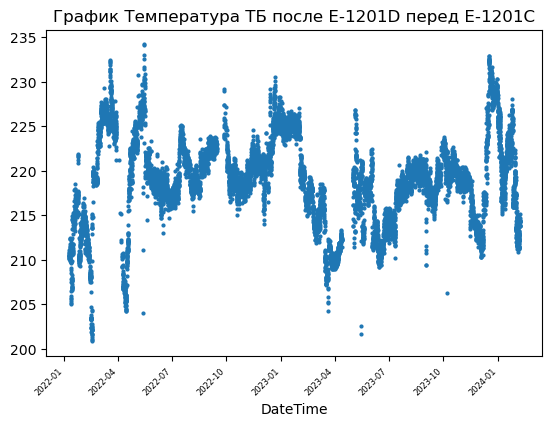

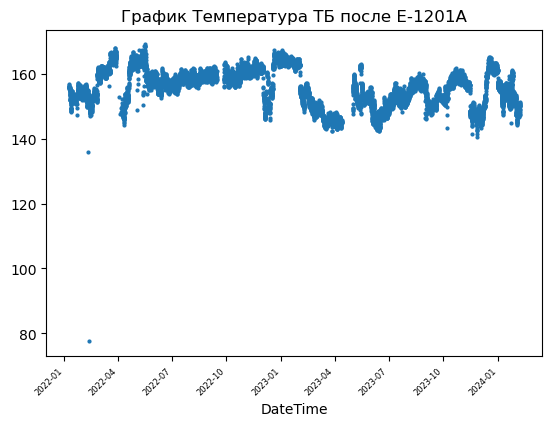

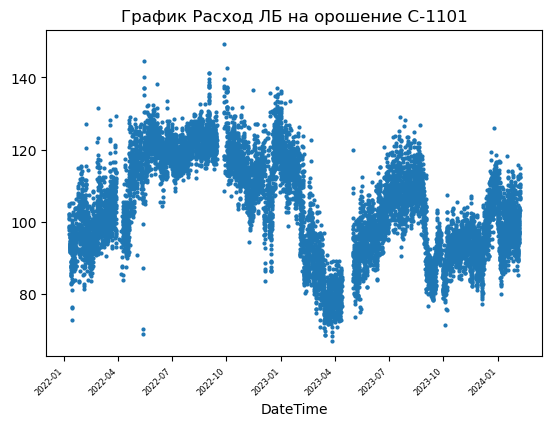

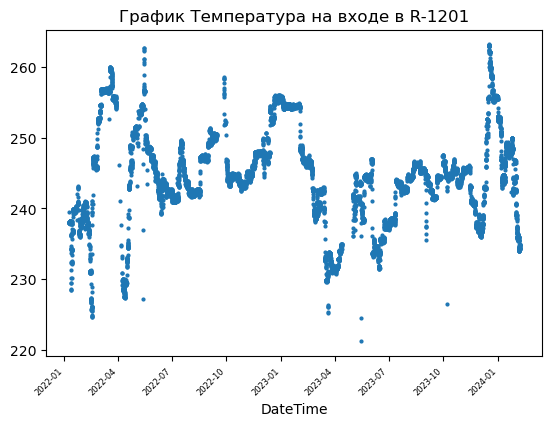

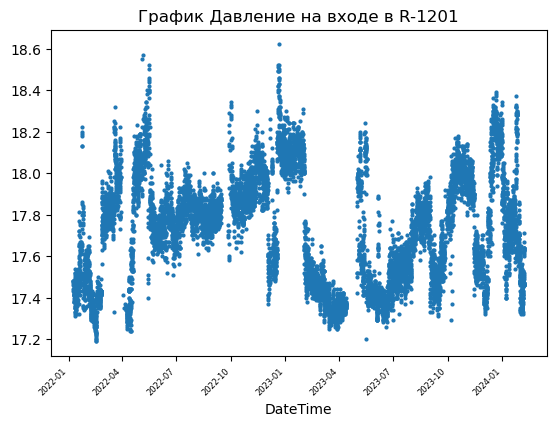

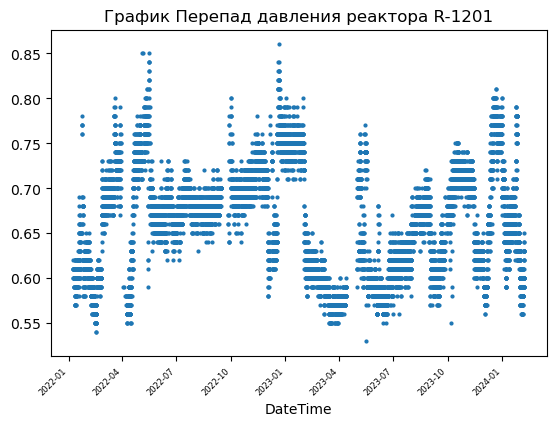

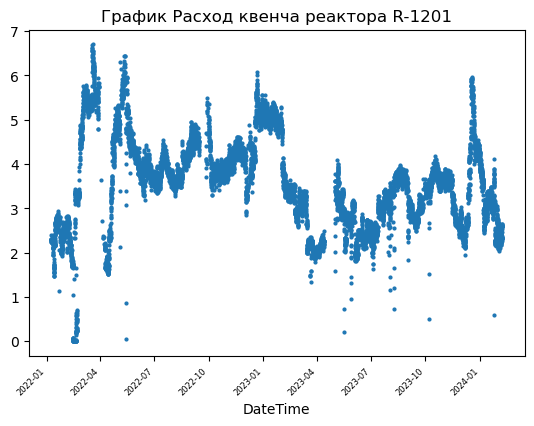

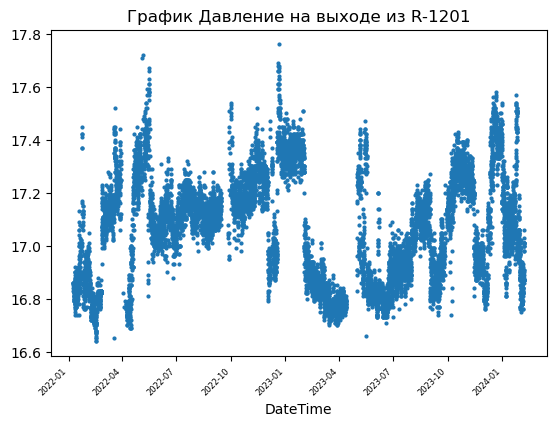

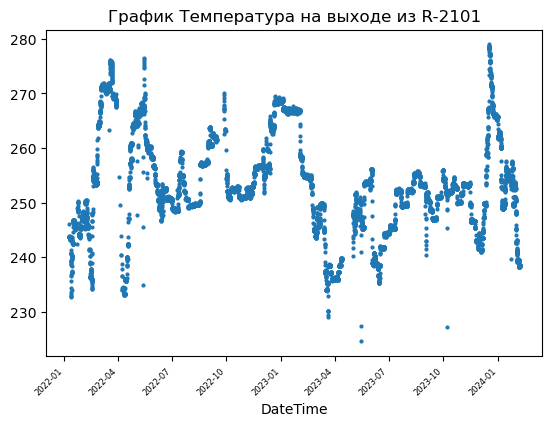

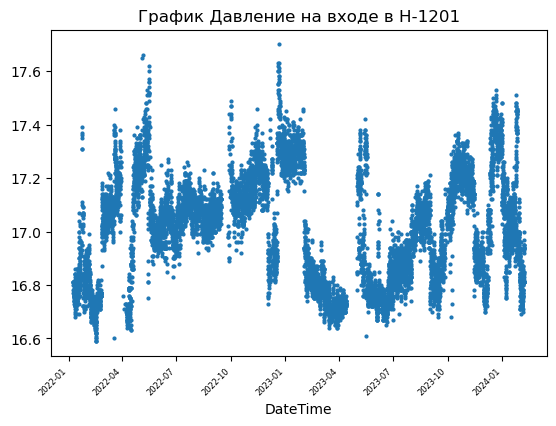

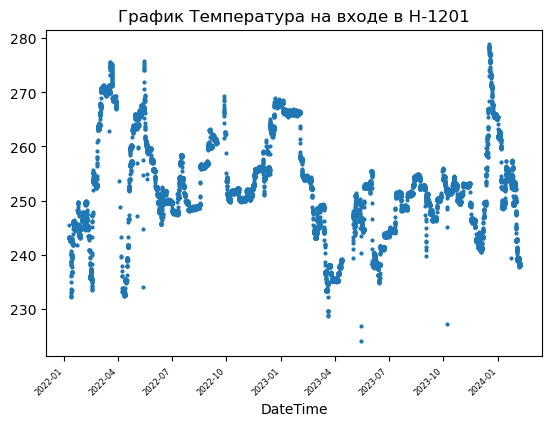

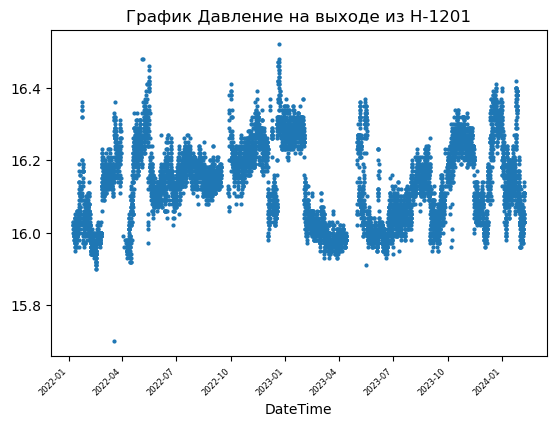

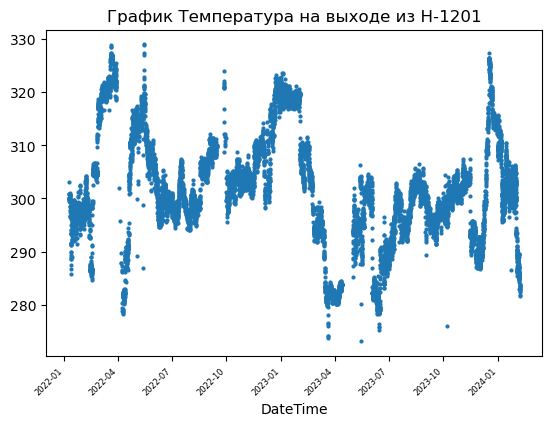

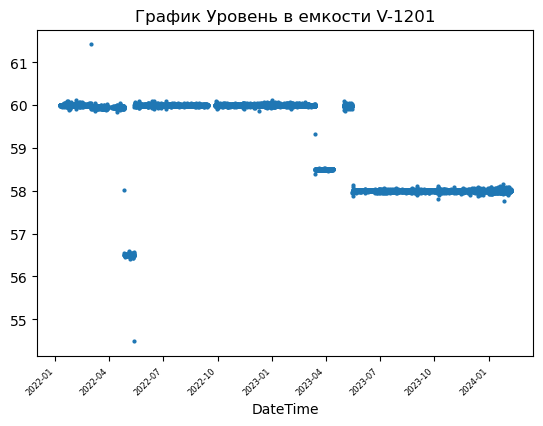

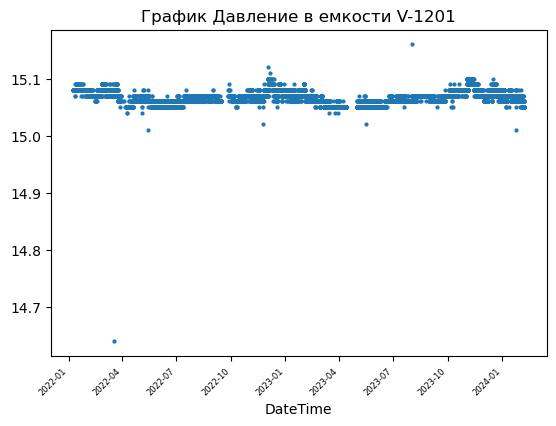

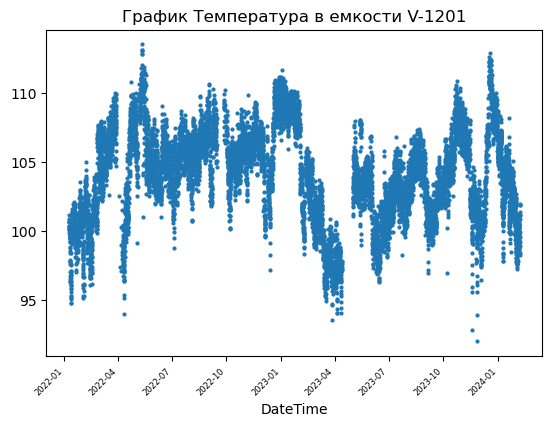

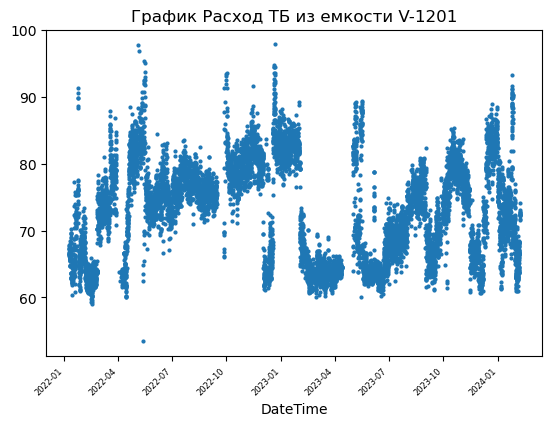

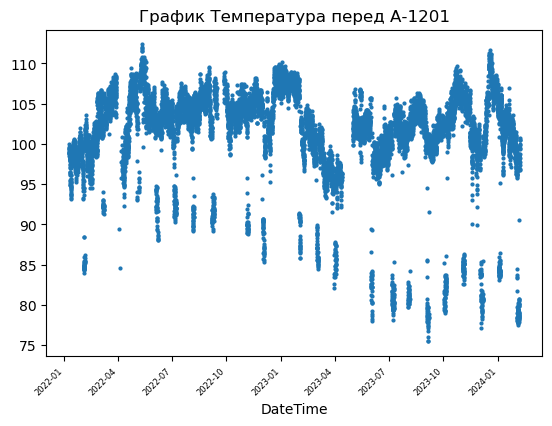

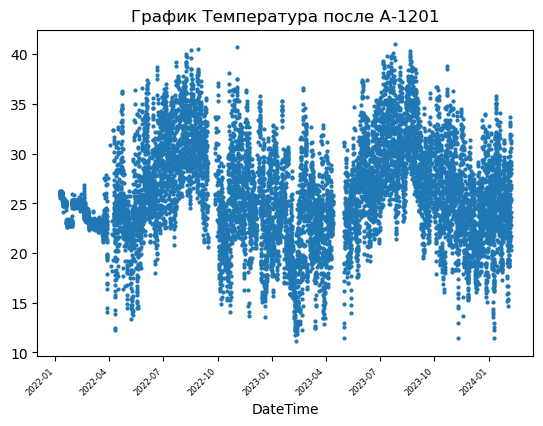

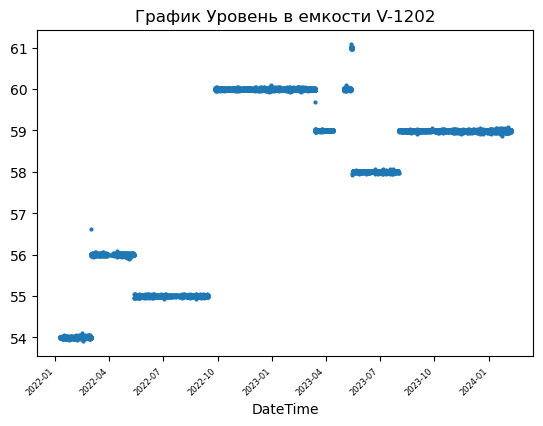

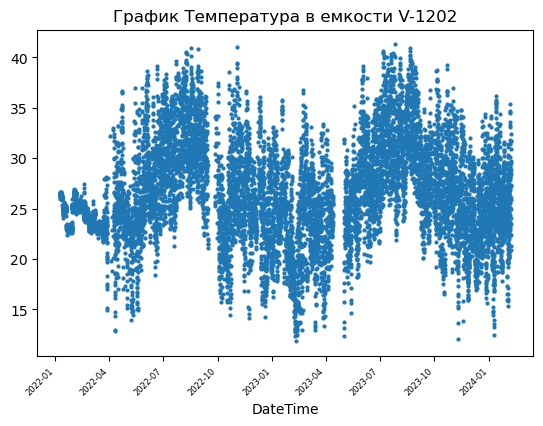

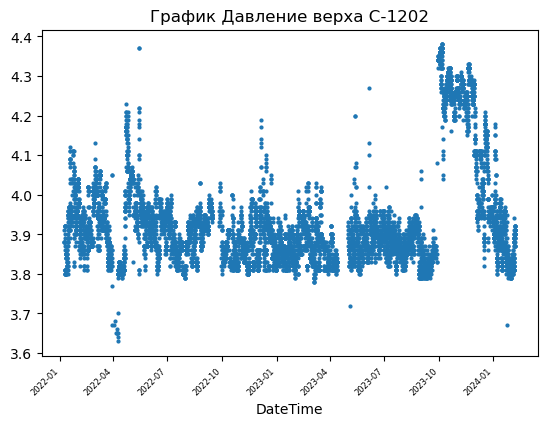

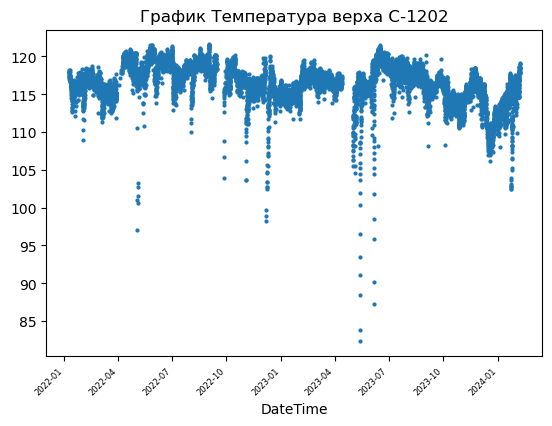

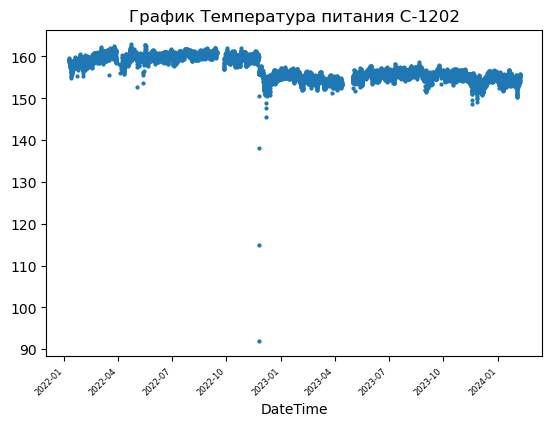

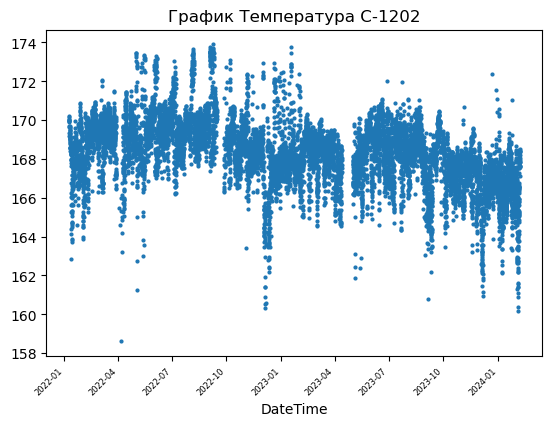

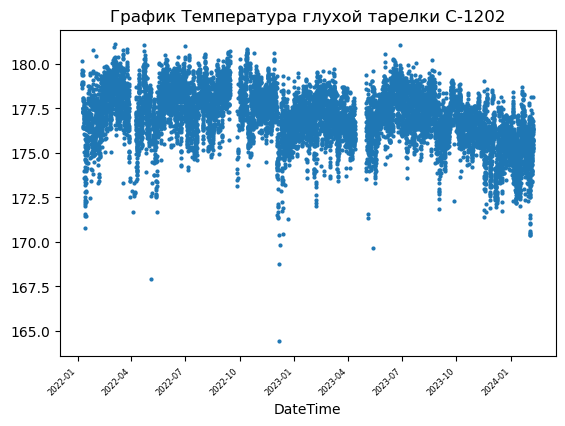

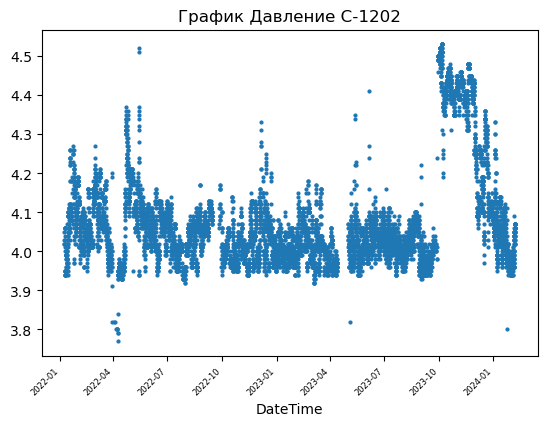

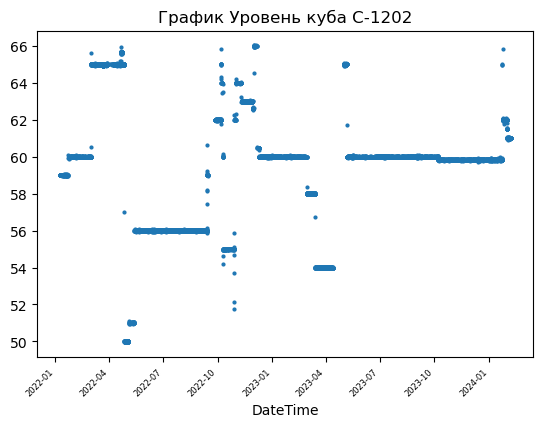

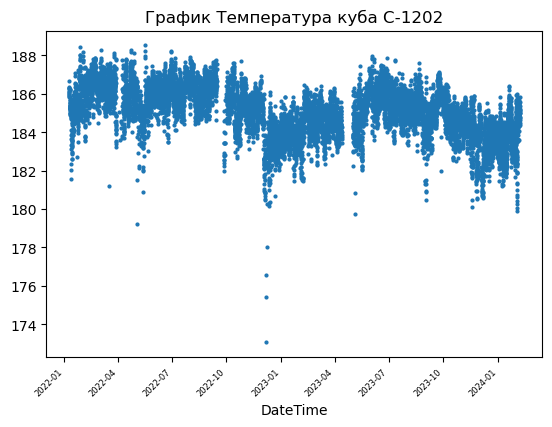

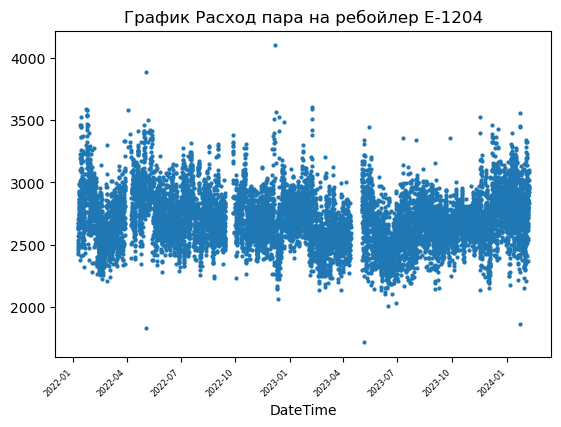

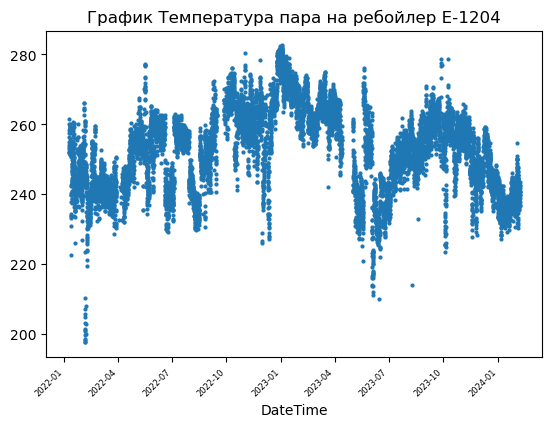

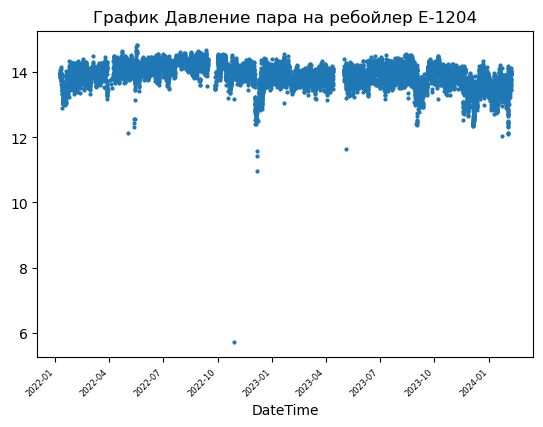

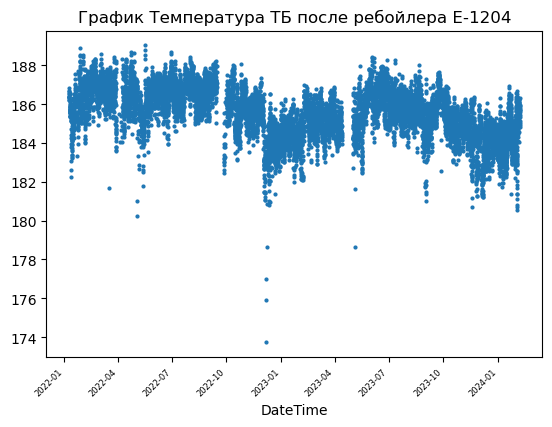

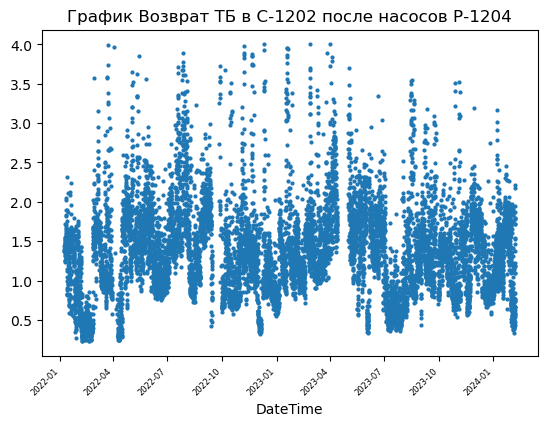

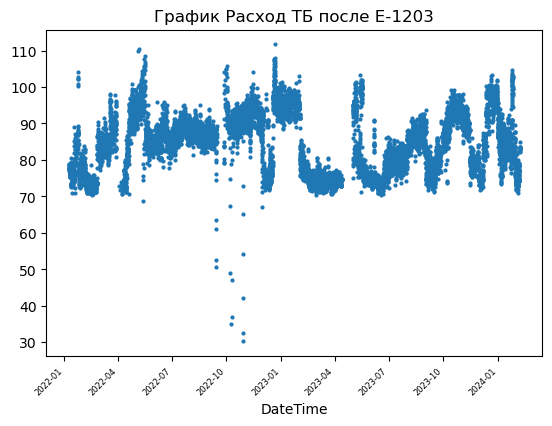

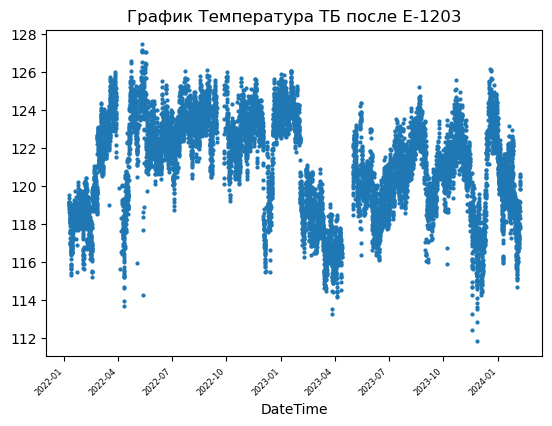

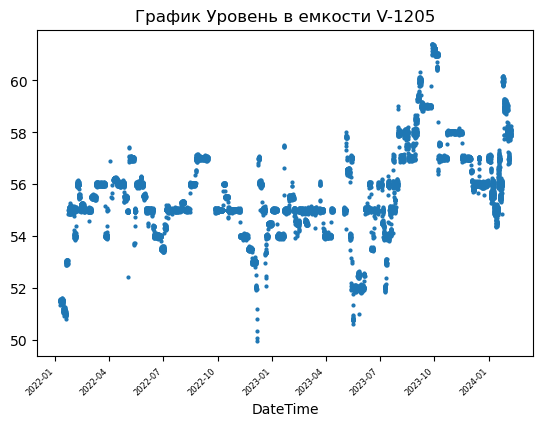

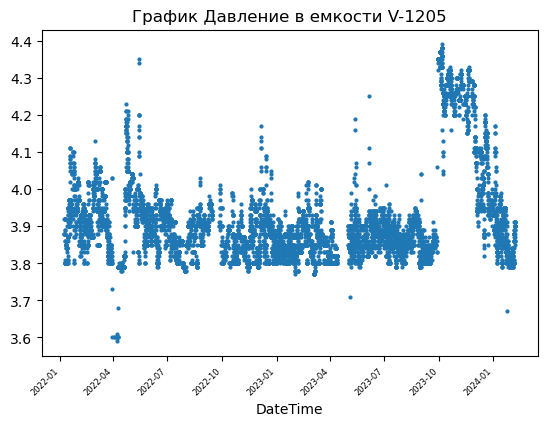

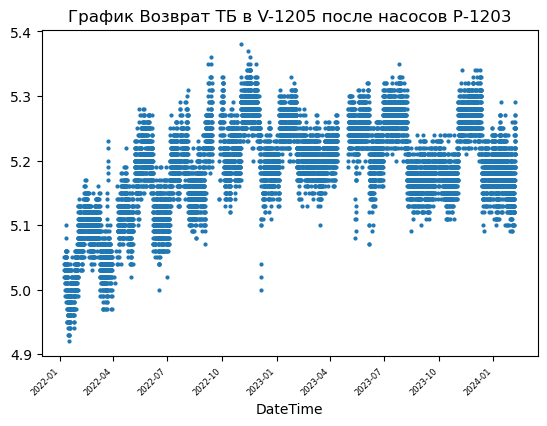

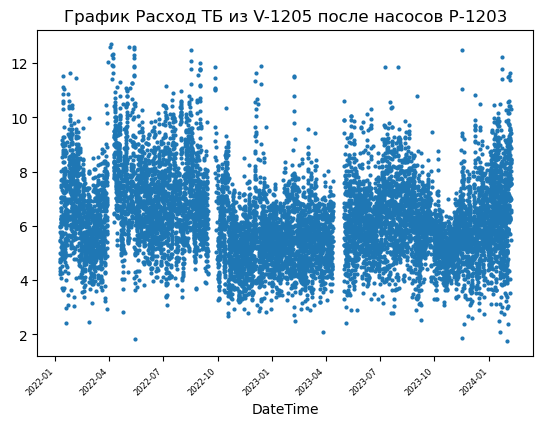

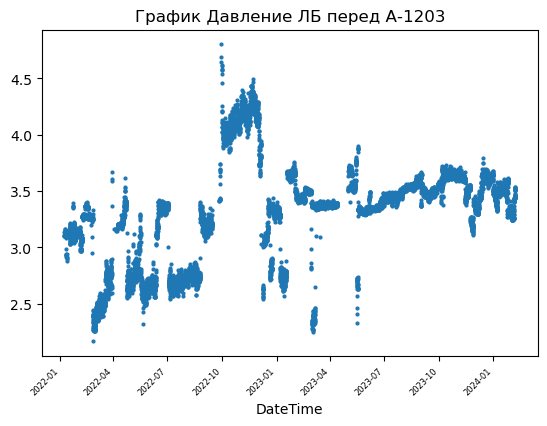

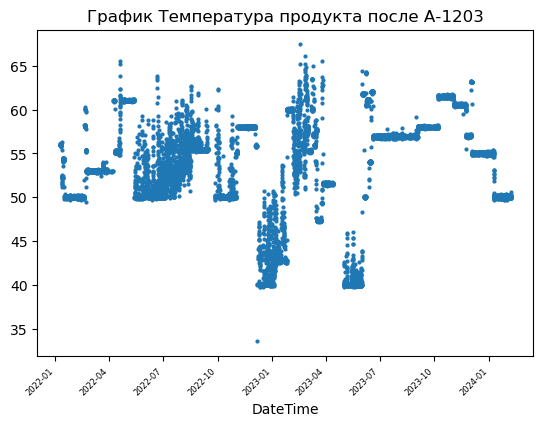

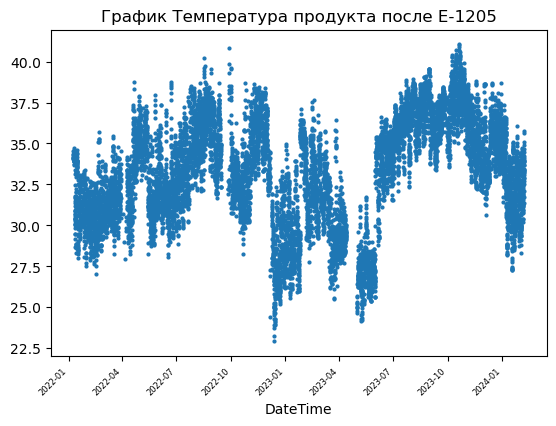

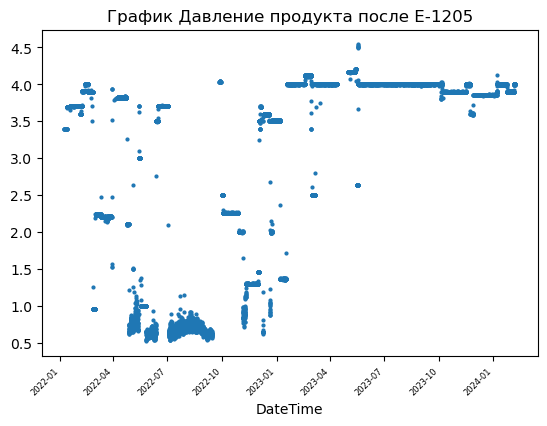

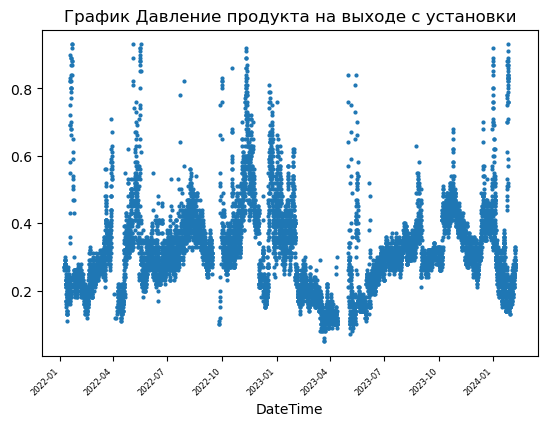

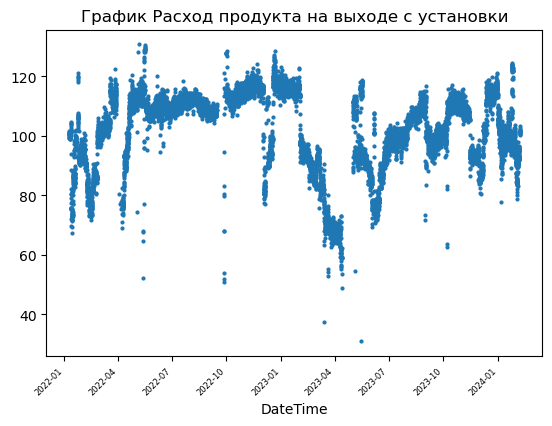

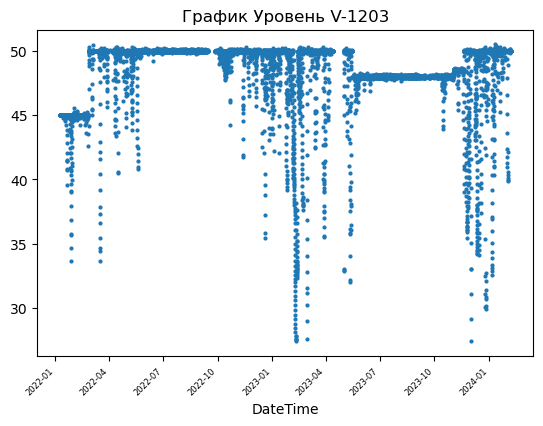

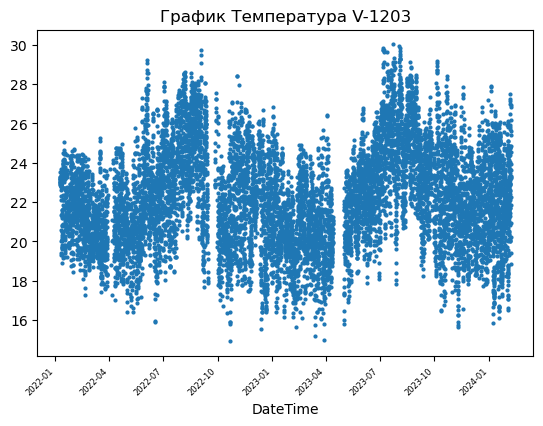

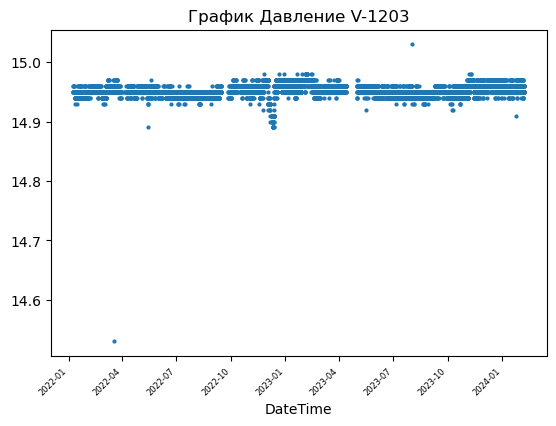

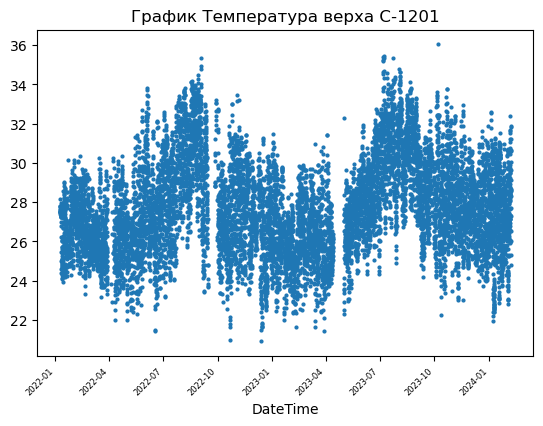

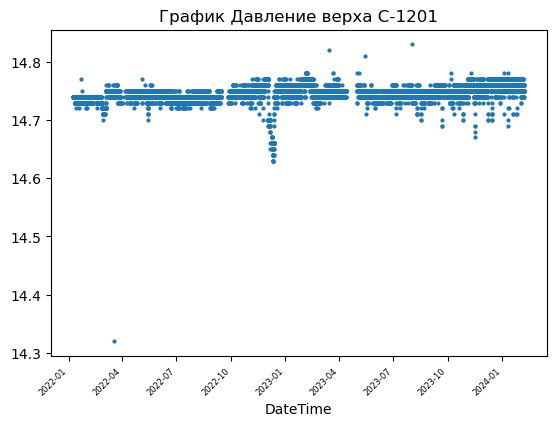

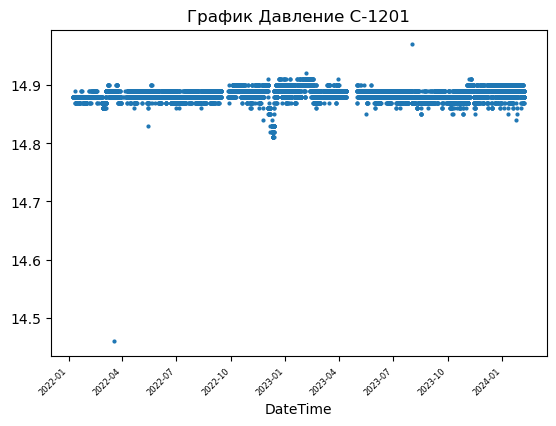

In [16]:
parameter_vis(filtered_df_1)